# Modulation Recognition with Deep Learning
# This notebook is for the CNN

We try fully connected feed forward neural networks as a baseline to classify 11 different modulation schemes. We compare the performance of the more sophisticated convolutional neural networks against the baseline.

## Downloading the data set

In [0]:
!curl http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2 --output dataset.pkl.bz2
!bzip2 -d dataset.pkl.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

In [0]:
!rm -rf dataset.pkl.bz2

In [0]:
#@title Default title text
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

## Python imports

In [0]:
import tensorflow
import keras
import pickle
import h5py
import numpy as np
import pydot
# import graphviz


# h5py.run_tests()
from keras.models import Sequential
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import random, sys

Using TensorFlow backend.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Importing the dataset

In [0]:
# The dataset is a pickle file of a serialized python dictionary object where
# its keys are a 2-tuples of (modulation scheme name, SNR)
# SNR ranges from -20 to 20 dB with step size of 2

# set encoding because of incompatibility issue between python 2 and python 3
dataset = pickle._Unpickler(open("dataset.pkl","rb"), encoding='latin1').load()

In [0]:
print(dataset[('BPSK', 10)].shape)

(1247, 2, 128)


In [0]:
modulations = set()

for key in dataset:
    modulations.add(key[0])

modulations_dict = dict([(name, num) for num, name in enumerate(modulations)])
print(modulations_dict)
snrs = np.linspace(-20, 18, 20, dtype=int)
print(snrs)
mods = modulations

{'CPFSK': 0, 'QAM16': 1, 'QPSK': 2, 'BPSK': 3, 'WBFM': 4, 'PAM4': 5, 'QAM64': 6, '8PSK': 7, 'GFSK': 8, 'AM-SSB': 9, 'AM-DSB': 10}
[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18]


In [0]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [0]:
def get_data_matrix(dataset, train_test_split=0.5, normalize=False, diff=False, integration=False):
#  split the data in the shape of (rows,2,128)
# get numbers of rows
    rows = 0
    for key in dataset:
        rows += dataset[key].shape[0]

    X = np.empty([rows, dataset[key].shape[1], dataset[key].shape[2]])
    y = []
    lbl = []
    idx = 0
    for key in dataset:
        for item in dataset[key]:
            tmp = np.array(item).reshape((dataset[key].shape[1], dataset[key].shape[2]))
            X[idx] = tmp
            y.append(modulations_dict[key[0]])
            lbl.append(key)
            idx += 1
    if normalize or diff or integration :
      num_row_per_feature = dataset[key].shape[1]
      
      if integration:
        num_row_per_feature +=2
      if diff:
        num_row_per_feature +=2
      
      X_opp=np.empty([rows, num_row_per_feature, dataset[key].shape[2]])
      
      for idx in range(rows):
        tmp_normalize = np.empty([dataset[key].shape[1], dataset[key].shape[2]])
        tmp_diff = np.empty([dataset[key].shape[1], dataset[key].shape[2]])
        tmp_integration = np.empty([dataset[key].shape[1], dataset[key].shape[2]])
        if normalize:
          X_mean = X[idx].mean().astype(np.float32)
          X_sdev = X[idx].std().astype(np.float32)
          tmp_normalize = (X[idx] - X_mean)/X_sdev
        else :
          tmp_normalize = X[idx]
        if diff :
          tmp_diff = np.gradient(X[idx], axis=1)
        if integration :
          for idx1 in range(X[idx].shape[0]):
            currentVec=X[idx,idx1,::].reshape((1,X.shape[2]))
            anti_der = UnivariateSpline(np.linspace(0,1,128),currentVec).antiderivative()                            
            anti_der = np.array([anti_der(i) for i in np.linspace(0,1,128)]).reshape(1,128)
            tmp_integration[idx1] = anti_der
       
        if diff and integration:  
          X_opp[idx] = np.concatenate((tmp_normalize,tmp_diff,tmp_integration), axis=0)
        elif diff :  
          X_opp[idx] = np.concatenate((tmp_normalize,tmp_diff), axis=0)
        elif integration :  
          X_opp[idx] = np.concatenate((tmp_normalize,tmp_integration), axis=0)
        else:  
          X_opp[idx] = np.concatenate((tmp_normalize), axis=0)
         
        idx += 1          
        
#     make one hot to represent y
    y = np.array(to_onehot(y), dtype=int)
    lbl = np.array(lbl)
    if diff or integration:
      X = X_opp
    # Partition the data
    np.random.seed(2016)
    n_examples = X.shape[0]
    n_train = int(n_examples * train_test_split)

    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx))

    X_train = X[train_idx]
    X_test =  X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    lbl_train = lbl[train_idx]
    lbl_test = lbl[test_idx]
    return X_train, y_train, lbl_train, X_test, y_test, lbl_test
  
# features are in this order if all present row data , diff data, intg data
X_train, y_train, lbl_train, X_test, y_test, lbl_test = get_data_matrix(dataset,normalize=True, integration=True, diff = True)            

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
A theoretically impossible result was found during the iteration
proces for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [0]:
def cross_validate(total_size, val_set_size):
    n_examples = total_size
    n_data = int(n_examples * (1-val_set_size))
    data_idx = np.random.choice(range(0,n_examples), size=n_data, replace=False)
    val_idx = list(set(range(0,n_examples))-set(data_idx))
    return [(np.array(data_idx), np.array(val_idx))]
    

In [0]:
def cnn_Model (in_shp,dr):
  model = Sequential()
  model.add(Reshape(in_shp+[1], input_shape=in_shp))
  model.add(ZeroPadding2D((0, 1), data_format='channels_last'))
  model.add(Conv2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 1), data_format='channels_last'))
  model.add(Conv2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
  model.add(Dropout(dr))
  model.add(Dense(11, init='he_normal', name="dense2" ))
  model.add(Activation('softmax'))
  model.add(Reshape([11]))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
  model.summary()
  return model

In [0]:
#  early stop callback

class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, monitor='loss', value=0.01, verbose=0):
        super(keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
callbacks = [
    EarlyStoppingByLossVal(monitor='loss', value=0.00001, verbose=1),
]

In [0]:
# cnn_Model ([X_train.shape[1],X_train.shape[2]],0.5)

In [0]:
def feature_tuning (features):
  models =[]
  for feature in features:
    models.append(cnn_Model ([X_train[:,feature[0]:feature[1]].shape[1],X_train.shape[2]],0.5))
  return models

In [0]:
params =[[0,2], [2,4], [4,6], [0,4], [2,6], [0,6]]
models=feature_tuning(params)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, name="dense2", kernel_initializer="he_normal")`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 130, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 128, 256)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 130, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 128, 80)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128, 80)        0         
__________

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Train on 76978 samples, validate on 4052 samples
Epoch 1/30
59424/76978 [======================>.......] - ETA: 10s - loss: 1.5789 - categorical_accuracy: 0.4087

76978/76978 [==============================] - 48s 622us/step - loss: 1.5385 - categorical_accuracy: 0.4211 - val_loss: 1.3035 - val_categorical_accuracy: 0.4941
Epoch 2/30
28416/76978 [==========>...................] - ETA: 28s - loss: 1.3484 - categorical_accuracy: 0.4891

76978/76978 [==============================] - 46s 597us/step - loss: 1.3232 - categorical_accuracy: 0.5024 - val_loss: 1.1873 - val_categorical_accuracy: 0.5496
Epoch 3/30
17024/76978 [=====>........................] - ETA: 35s - loss: 1.2533 - categorical_accuracy: 0.5322

76978/76978 [==============================] - 46s 602us/step - loss: 1.2553 - categorical_accuracy: 0.5304 - val_loss: 1.1844 - val_categorical_accuracy: 0.5501
Epoch 4/30
12800/76978 [===>..........................] - ETA: 38s - loss: 1.2297 - categorical_accuracy: 0.5389

76978/76978 [==============================] - 46s 603us/step - loss: 1.2291 - categorical_accuracy: 0.5363 - val_loss: 1.1732 - val_categorical_accuracy: 0.5523
Epoch 5/30
11264/76978 [===>..........................] - ETA: 39s - loss: 1.2097 - categorical_accuracy: 0.5462

76978/76978 [==============================] - 46s 603us/step - loss: 1.2103 - categorical_accuracy: 0.5458 - val_loss: 1.1558 - val_categorical_accuracy: 0.5597
Epoch 6/30
10688/76978 [===>..........................] - ETA: 39s - loss: 1.2051 - categorical_accuracy: 0.5502

76978/76978 [==============================] - 47s 604us/step - loss: 1.1955 - categorical_accuracy: 0.5513 - val_loss: 1.1361 - val_categorical_accuracy: 0.5706
Epoch 7/30
10496/76978 [===>..........................] - ETA: 39s - loss: 1.1647 - categorical_accuracy: 0.5678

76978/76978 [==============================] - 46s 600us/step - loss: 1.1791 - categorical_accuracy: 0.5579 - val_loss: 1.1520 - val_categorical_accuracy: 0.5494
Epoch 8/30
10400/76978 [===>..........................] - ETA: 39s - loss: 1.1678 - categorical_accuracy: 0.5654

76978/76978 [==============================] - 46s 602us/step - loss: 1.1719 - categorical_accuracy: 0.5608 - val_loss: 1.1453 - val_categorical_accuracy: 0.5605
Epoch 9/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.1621 - categorical_accuracy: 0.5707

76978/76978 [==============================] - 46s 600us/step - loss: 1.1640 - categorical_accuracy: 0.5649 - val_loss: 1.1387 - val_categorical_accuracy: 0.5661
Epoch 10/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.1496 - categorical_accuracy: 0.5667

76978/76978 [==============================] - 46s 597us/step - loss: 1.1536 - categorical_accuracy: 0.5678 - val_loss: 1.1482 - val_categorical_accuracy: 0.5679
Epoch 11/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.1330 - categorical_accuracy: 0.5791

76978/76978 [==============================] - 46s 599us/step - loss: 1.1455 - categorical_accuracy: 0.5728 - val_loss: 1.1319 - val_categorical_accuracy: 0.5671
Epoch 12/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.1307 - categorical_accuracy: 0.5843

76978/76978 [==============================] - 46s 603us/step - loss: 1.1388 - categorical_accuracy: 0.5740 - val_loss: 1.1418 - val_categorical_accuracy: 0.5602
Epoch 13/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.1180 - categorical_accuracy: 0.5814

76978/76978 [==============================] - 46s 597us/step - loss: 1.1293 - categorical_accuracy: 0.5779 - val_loss: 1.1386 - val_categorical_accuracy: 0.5713
Epoch 14/30
10272/76978 [===>..........................] - ETA: 40s - loss: 1.1304 - categorical_accuracy: 0.5797

76978/76978 [==============================] - 47s 607us/step - loss: 1.1261 - categorical_accuracy: 0.5806 - val_loss: 1.1283 - val_categorical_accuracy: 0.5706
Epoch 15/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.0910 - categorical_accuracy: 0.5888

76978/76978 [==============================] - 46s 602us/step - loss: 1.1154 - categorical_accuracy: 0.5837 - val_loss: 1.1355 - val_categorical_accuracy: 0.5753
Epoch 16/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.1081 - categorical_accuracy: 0.5889

76978/76978 [==============================] - 46s 594us/step - loss: 1.1156 - categorical_accuracy: 0.5861 - val_loss: 1.1272 - val_categorical_accuracy: 0.5733
Epoch 17/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.1016 - categorical_accuracy: 0.5942

76978/76978 [==============================] - 46s 592us/step - loss: 1.1076 - categorical_accuracy: 0.5896 - val_loss: 1.1320 - val_categorical_accuracy: 0.5669
Epoch 18/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.1123 - categorical_accuracy: 0.5888

76978/76978 [==============================] - 46s 594us/step - loss: 1.1006 - categorical_accuracy: 0.5916 - val_loss: 1.1449 - val_categorical_accuracy: 0.5703
Epoch 19/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0958 - categorical_accuracy: 0.5906

76978/76978 [==============================] - 46s 597us/step - loss: 1.1013 - categorical_accuracy: 0.5915 - val_loss: 1.1339 - val_categorical_accuracy: 0.5740
Epoch 20/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.0816 - categorical_accuracy: 0.6011

76978/76978 [==============================] - 46s 594us/step - loss: 1.0898 - categorical_accuracy: 0.5953 - val_loss: 1.1341 - val_categorical_accuracy: 0.5763
Epoch 21/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0901 - categorical_accuracy: 0.5988

76978/76978 [==============================] - 46s 594us/step - loss: 1.0892 - categorical_accuracy: 0.5968 - val_loss: 1.1308 - val_categorical_accuracy: 0.5772
Epoch 22/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0785 - categorical_accuracy: 0.6048

76978/76978 [==============================] - 46s 592us/step - loss: 1.0847 - categorical_accuracy: 0.6002 - val_loss: 1.1342 - val_categorical_accuracy: 0.5731
Epoch 23/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.0699 - categorical_accuracy: 0.6027

76978/76978 [==============================] - 46s 594us/step - loss: 1.0807 - categorical_accuracy: 0.5995 - val_loss: 1.1342 - val_categorical_accuracy: 0.5716
Epoch 24/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0528 - categorical_accuracy: 0.6096

76978/76978 [==============================] - 46s 597us/step - loss: 1.0762 - categorical_accuracy: 0.6011 - val_loss: 1.1408 - val_categorical_accuracy: 0.5735
Epoch 25/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0829 - categorical_accuracy: 0.5967

76978/76978 [==============================] - 46s 596us/step - loss: 1.0716 - categorical_accuracy: 0.6038 - val_loss: 1.1284 - val_categorical_accuracy: 0.5768
Epoch 26/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0751 - categorical_accuracy: 0.6033

76978/76978 [==============================] - 46s 596us/step - loss: 1.0691 - categorical_accuracy: 0.6043 - val_loss: 1.1284 - val_categorical_accuracy: 0.5755
Epoch 27/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0578 - categorical_accuracy: 0.6103

76978/76978 [==============================] - 46s 595us/step - loss: 1.0643 - categorical_accuracy: 0.6057 - val_loss: 1.1370 - val_categorical_accuracy: 0.5738
Epoch 28/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0485 - categorical_accuracy: 0.6128

76978/76978 [==============================] - 46s 594us/step - loss: 1.0641 - categorical_accuracy: 0.6068 - val_loss: 1.1406 - val_categorical_accuracy: 0.5713
Epoch 29/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.0393 - categorical_accuracy: 0.6219

76978/76978 [==============================] - 46s 594us/step - loss: 1.0578 - categorical_accuracy: 0.6097 - val_loss: 1.1440 - val_categorical_accuracy: 0.5698
Epoch 30/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.0485 - categorical_accuracy: 0.6125

42592/81030 [==============>...............] - ETA: 6s

81030/81030 [==============================] - 14s 169us/step
Overall Accuracy:  0.09253365973072215
Overall Accuracy:  0.08965344048216976
Overall Accuracy:  0.10270404366162243
Overall Accuracy:  0.09259711702907403
Overall Accuracy:  0.11023036908595492
Overall Accuracy:  0.12540432943518287
Overall Accuracy:  0.24522370012091899
Overall Accuracy:  0.47175495857393923
Overall Accuracy:  0.6966707768187423
Overall Accuracy:  0.8107186358099878
Overall Accuracy:  0.8408977556109726
Overall Accuracy:  0.8745948641236599
Overall Accuracy:  0.8809349890430972
Overall Accuracy:  0.8855465884079237
Overall Accuracy:  0.870320528505016
Overall Accuracy:  0.8968696918223732
Overall Accuracy:  0.8753753753753754
Overall Accuracy:  0.871399696816574
Overall Accuracy:  0.8776215149272144


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Overall Accuracy:  0.879450036827891
Train on 76978 samples, validate on 4052 samples
Epoch 1/30
48320/76978 [=================>............] - ETA: 17s - loss: 1.7253 - categorical_accuracy: 0.3507

76978/76978 [==============================] - 46s 602us/step - loss: 1.6284 - categorical_accuracy: 0.3792 - val_loss: 1.3629 - val_categorical_accuracy: 0.4576
Epoch 2/30
24320/76978 [========>.....................] - ETA: 30s - loss: 1.4308 - categorical_accuracy: 0.4394

76978/76978 [==============================] - 46s 594us/step - loss: 1.4094 - categorical_accuracy: 0.4469 - val_loss: 1.3165 - val_categorical_accuracy: 0.4756
Epoch 3/30
15392/76978 [====>.........................] - ETA: 36s - loss: 1.3716 - categorical_accuracy: 0.4578

76978/76978 [==============================] - 46s 598us/step - loss: 1.3671 - categorical_accuracy: 0.4604 - val_loss: 1.2845 - val_categorical_accuracy: 0.4862
Epoch 4/30
12224/76978 [===>..........................] - ETA: 38s - loss: 1.3489 - categorical_accuracy: 0.4736

76978/76978 [==============================] - 46s 594us/step - loss: 1.3455 - categorical_accuracy: 0.4695 - val_loss: 1.2924 - val_categorical_accuracy: 0.4832
Epoch 5/30
11072/76978 [===>..........................] - ETA: 38s - loss: 1.3380 - categorical_accuracy: 0.4771

76978/76978 [==============================] - 46s 598us/step - loss: 1.3362 - categorical_accuracy: 0.4727 - val_loss: 1.2749 - val_categorical_accuracy: 0.4891
Epoch 6/30
10592/76978 [===>..........................] - ETA: 38s - loss: 1.3194 - categorical_accuracy: 0.4773

76978/76978 [==============================] - 46s 594us/step - loss: 1.3286 - categorical_accuracy: 0.4742 - val_loss: 1.2927 - val_categorical_accuracy: 0.4847
Epoch 7/30
10400/76978 [===>..........................] - ETA: 39s - loss: 1.3114 - categorical_accuracy: 0.4782

76978/76978 [==============================] - 46s 594us/step - loss: 1.3261 - categorical_accuracy: 0.4777 - val_loss: 1.2812 - val_categorical_accuracy: 0.4956
Epoch 8/30
10400/76978 [===>..........................] - ETA: 39s - loss: 1.3085 - categorical_accuracy: 0.4803

76978/76978 [==============================] - 46s 593us/step - loss: 1.3182 - categorical_accuracy: 0.4810 - val_loss: 1.2694 - val_categorical_accuracy: 0.4904
Epoch 9/30
10400/76978 [===>..........................] - ETA: 38s - loss: 1.2956 - categorical_accuracy: 0.4955

76978/76978 [==============================] - 46s 592us/step - loss: 1.3166 - categorical_accuracy: 0.4849 - val_loss: 1.2806 - val_categorical_accuracy: 0.4970
Epoch 10/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3070 - categorical_accuracy: 0.4857

76978/76978 [==============================] - 46s 597us/step - loss: 1.3123 - categorical_accuracy: 0.4824 - val_loss: 1.3020 - val_categorical_accuracy: 0.4862
Epoch 11/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3048 - categorical_accuracy: 0.4880

76978/76978 [==============================] - 46s 595us/step - loss: 1.3088 - categorical_accuracy: 0.4852 - val_loss: 1.2638 - val_categorical_accuracy: 0.4948
Epoch 12/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3035 - categorical_accuracy: 0.4876

76978/76978 [==============================] - 46s 600us/step - loss: 1.3062 - categorical_accuracy: 0.4857 - val_loss: 1.2586 - val_categorical_accuracy: 0.5000
Epoch 13/30
10208/76978 [==>...........................] - ETA: 39s - loss: 1.2886 - categorical_accuracy: 0.4924

76978/76978 [==============================] - 46s 597us/step - loss: 1.3019 - categorical_accuracy: 0.4895 - val_loss: 1.2828 - val_categorical_accuracy: 0.4891
Epoch 14/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2897 - categorical_accuracy: 0.4903

76978/76978 [==============================] - 46s 597us/step - loss: 1.3019 - categorical_accuracy: 0.4890 - val_loss: 1.2648 - val_categorical_accuracy: 0.4951
Epoch 15/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2909 - categorical_accuracy: 0.4953

76978/76978 [==============================] - 46s 594us/step - loss: 1.2992 - categorical_accuracy: 0.4911 - val_loss: 1.2698 - val_categorical_accuracy: 0.4933
Epoch 16/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.2929 - categorical_accuracy: 0.4860

76978/76978 [==============================] - 46s 594us/step - loss: 1.2988 - categorical_accuracy: 0.4904 - val_loss: 1.2553 - val_categorical_accuracy: 0.5020
Epoch 17/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3077 - categorical_accuracy: 0.4895

76978/76978 [==============================] - 46s 593us/step - loss: 1.2975 - categorical_accuracy: 0.4904 - val_loss: 1.2919 - val_categorical_accuracy: 0.4852
Epoch 18/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2916 - categorical_accuracy: 0.4937

76978/76978 [==============================] - 46s 592us/step - loss: 1.2964 - categorical_accuracy: 0.4928 - val_loss: 1.2879 - val_categorical_accuracy: 0.4968
Epoch 19/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2811 - categorical_accuracy: 0.4924

76978/76978 [==============================] - 46s 600us/step - loss: 1.2890 - categorical_accuracy: 0.4932 - val_loss: 1.2700 - val_categorical_accuracy: 0.5000
Epoch 20/30
10272/76978 [===>..........................] - ETA: 39s - loss: 1.2898 - categorical_accuracy: 0.4919

76978/76978 [==============================] - 46s 600us/step - loss: 1.2904 - categorical_accuracy: 0.4945 - val_loss: 1.2663 - val_categorical_accuracy: 0.4988
Epoch 21/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2840 - categorical_accuracy: 0.4895

76978/76978 [==============================] - 46s 600us/step - loss: 1.2908 - categorical_accuracy: 0.4931 - val_loss: 1.2455 - val_categorical_accuracy: 0.5042
Epoch 22/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2736 - categorical_accuracy: 0.4908

76978/76978 [==============================] - 46s 603us/step - loss: 1.2868 - categorical_accuracy: 0.4957 - val_loss: 1.2653 - val_categorical_accuracy: 0.5020
Epoch 23/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2803 - categorical_accuracy: 0.4993

76978/76978 [==============================] - 46s 598us/step - loss: 1.2864 - categorical_accuracy: 0.4970 - val_loss: 1.2754 - val_categorical_accuracy: 0.4889
Epoch 24/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2957 - categorical_accuracy: 0.4992

76978/76978 [==============================] - 46s 597us/step - loss: 1.2844 - categorical_accuracy: 0.4981 - val_loss: 1.2974 - val_categorical_accuracy: 0.4869
Epoch 25/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2709 - categorical_accuracy: 0.5011

76978/76978 [==============================] - 46s 602us/step - loss: 1.2838 - categorical_accuracy: 0.4987 - val_loss: 1.2748 - val_categorical_accuracy: 0.4889
Epoch 26/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2818 - categorical_accuracy: 0.5036

76978/76978 [==============================] - 46s 600us/step - loss: 1.2817 - categorical_accuracy: 0.4990 - val_loss: 1.2823 - val_categorical_accuracy: 0.4938
Epoch 27/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2979 - categorical_accuracy: 0.4865

76978/76978 [==============================] - 46s 602us/step - loss: 1.2853 - categorical_accuracy: 0.4965 - val_loss: 1.2668 - val_categorical_accuracy: 0.4963
Epoch 28/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.2759 - categorical_accuracy: 0.5073

76978/76978 [==============================] - 46s 602us/step - loss: 1.2812 - categorical_accuracy: 0.4991 - val_loss: 1.2569 - val_categorical_accuracy: 0.5079
Epoch 29/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2933 - categorical_accuracy: 0.4941

76978/76978 [==============================] - 46s 599us/step - loss: 1.2833 - categorical_accuracy: 0.4990 - val_loss: 1.2663 - val_categorical_accuracy: 0.4998
Epoch 30/30
10304/76978 [===>..........................] - ETA: 38s - loss: 1.2813 - categorical_accuracy: 0.5019

42880/81030 [==============>...............] - ETA: 6s

81030/81030 [==============================] - 14s 171us/step
Overall Accuracy:  0.1481028151774786
Overall Accuracy:  0.15469613259668508
Overall Accuracy:  0.15604068469362442
Overall Accuracy:  0.14610310285853897
Overall Accuracy:  0.15605647758236313
Overall Accuracy:  0.15824832047773077
Overall Accuracy:  0.15598548972188633
Overall Accuracy:  0.25407983931709766
Overall Accuracy:  0.3684340320591862
Overall Accuracy:  0.49914738124238733
Overall Accuracy:  0.6768079800498753
Overall Accuracy:  0.7384692096733981
Overall Accuracy:  0.75700024348673
Overall Accuracy:  0.8048422597212033
Overall Accuracy:  0.7974064105701003
Overall Accuracy:  0.8167920407668042
Overall Accuracy:  0.8135635635635635
Overall Accuracy:  0.8130368873168267
Overall Accuracy:  0.8151986183074266
Overall Accuracy:  0.80947704394795
Train on 76978 samples, validate on 4052 samples
Epoch 1/30
 7872/76978 [==>...........................] - ETA: 46s - loss: 2.1941 - categorical_accuracy: 0.2355

76978/76978 [==============================] - 47s 613us/step - loss: 1.8589 - categorical_accuracy: 0.3262 - val_loss: 1.6867 - val_categorical_accuracy: 0.3611
Epoch 2/30
 9440/76978 [==>...........................] - ETA: 40s - loss: 1.6959 - categorical_accuracy: 0.3664

76978/76978 [==============================] - 47s 610us/step - loss: 1.6538 - categorical_accuracy: 0.3812 - val_loss: 1.5519 - val_categorical_accuracy: 0.4109
Epoch 3/30
10016/76978 [==>...........................] - ETA: 40s - loss: 1.5964 - categorical_accuracy: 0.3972

76978/76978 [==============================] - 47s 608us/step - loss: 1.5937 - categorical_accuracy: 0.4025 - val_loss: 1.5182 - val_categorical_accuracy: 0.4240
Epoch 4/30
10208/76978 [==>...........................] - ETA: 40s - loss: 1.5463 - categorical_accuracy: 0.4226

76978/76978 [==============================] - 47s 612us/step - loss: 1.5401 - categorical_accuracy: 0.4181 - val_loss: 1.4618 - val_categorical_accuracy: 0.4462
Epoch 5/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.5226 - categorical_accuracy: 0.4240

76978/76978 [==============================] - 47s 612us/step - loss: 1.5083 - categorical_accuracy: 0.4290 - val_loss: 1.4165 - val_categorical_accuracy: 0.4593
Epoch 6/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.5038 - categorical_accuracy: 0.4365

76978/76978 [==============================] - 47s 607us/step - loss: 1.4818 - categorical_accuracy: 0.4402 - val_loss: 1.3926 - val_categorical_accuracy: 0.4672
Epoch 7/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.4645 - categorical_accuracy: 0.4495

76978/76978 [==============================] - 47s 605us/step - loss: 1.4526 - categorical_accuracy: 0.4494 - val_loss: 1.4010 - val_categorical_accuracy: 0.4563
Epoch 8/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.4411 - categorical_accuracy: 0.4558

76978/76978 [==============================] - 46s 602us/step - loss: 1.4340 - categorical_accuracy: 0.4554 - val_loss: 1.3264 - val_categorical_accuracy: 0.4852
Epoch 9/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.4050 - categorical_accuracy: 0.4669

76978/76978 [==============================] - 46s 602us/step - loss: 1.4128 - categorical_accuracy: 0.4621 - val_loss: 1.3267 - val_categorical_accuracy: 0.4884
Epoch 10/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.4047 - categorical_accuracy: 0.4605

76978/76978 [==============================] - 47s 606us/step - loss: 1.4006 - categorical_accuracy: 0.4649 - val_loss: 1.2977 - val_categorical_accuracy: 0.4919
Epoch 11/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3856 - categorical_accuracy: 0.4768

76978/76978 [==============================] - 46s 602us/step - loss: 1.3855 - categorical_accuracy: 0.4724 - val_loss: 1.2914 - val_categorical_accuracy: 0.4988
Epoch 12/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3727 - categorical_accuracy: 0.4766

76978/76978 [==============================] - 46s 601us/step - loss: 1.3704 - categorical_accuracy: 0.4775 - val_loss: 1.2744 - val_categorical_accuracy: 0.5047
Epoch 13/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3502 - categorical_accuracy: 0.4879

76978/76978 [==============================] - 46s 602us/step - loss: 1.3592 - categorical_accuracy: 0.4836 - val_loss: 1.2696 - val_categorical_accuracy: 0.5084
Epoch 14/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3350 - categorical_accuracy: 0.4862

76978/76978 [==============================] - 46s 598us/step - loss: 1.3469 - categorical_accuracy: 0.4864 - val_loss: 1.2704 - val_categorical_accuracy: 0.5079
Epoch 15/30
10272/76978 [===>..........................] - ETA: 39s - loss: 1.3376 - categorical_accuracy: 0.4892

76978/76978 [==============================] - 46s 600us/step - loss: 1.3381 - categorical_accuracy: 0.4893 - val_loss: 1.2387 - val_categorical_accuracy: 0.5185
Epoch 16/30
10272/76978 [===>..........................] - ETA: 39s - loss: 1.3271 - categorical_accuracy: 0.4958

76978/76978 [==============================] - 46s 601us/step - loss: 1.3319 - categorical_accuracy: 0.4917 - val_loss: 1.2756 - val_categorical_accuracy: 0.4985
Epoch 17/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3236 - categorical_accuracy: 0.4971

76978/76978 [==============================] - 46s 602us/step - loss: 1.3212 - categorical_accuracy: 0.4957 - val_loss: 1.2379 - val_categorical_accuracy: 0.5178
Epoch 18/30
10208/76978 [==>...........................] - ETA: 39s - loss: 1.3145 - categorical_accuracy: 0.5013

76978/76978 [==============================] - 46s 602us/step - loss: 1.3129 - categorical_accuracy: 0.4989 - val_loss: 1.2248 - val_categorical_accuracy: 0.5205
Epoch 19/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.3104 - categorical_accuracy: 0.5034

76978/76978 [==============================] - 46s 604us/step - loss: 1.3045 - categorical_accuracy: 0.5026 - val_loss: 1.2294 - val_categorical_accuracy: 0.5254
Epoch 20/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.2960 - categorical_accuracy: 0.5024

76978/76978 [==============================] - 47s 606us/step - loss: 1.3021 - categorical_accuracy: 0.5028 - val_loss: 1.2294 - val_categorical_accuracy: 0.5114
Epoch 21/30
10272/76978 [===>..........................] - ETA: 40s - loss: 1.2941 - categorical_accuracy: 0.5011

76978/76978 [==============================] - 46s 604us/step - loss: 1.2957 - categorical_accuracy: 0.5026 - val_loss: 1.2265 - val_categorical_accuracy: 0.5205
Epoch 22/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2875 - categorical_accuracy: 0.5120

76978/76978 [==============================] - 46s 600us/step - loss: 1.2922 - categorical_accuracy: 0.5066 - val_loss: 1.2216 - val_categorical_accuracy: 0.5183
Epoch 23/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2745 - categorical_accuracy: 0.5181

76978/76978 [==============================] - 46s 601us/step - loss: 1.2876 - categorical_accuracy: 0.5080 - val_loss: 1.2295 - val_categorical_accuracy: 0.5212
Epoch 24/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.2640 - categorical_accuracy: 0.5197

76978/76978 [==============================] - 46s 601us/step - loss: 1.2847 - categorical_accuracy: 0.5097 - val_loss: 1.2108 - val_categorical_accuracy: 0.5308
Epoch 25/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.2822 - categorical_accuracy: 0.5041

76978/76978 [==============================] - 47s 606us/step - loss: 1.2797 - categorical_accuracy: 0.5091 - val_loss: 1.2253 - val_categorical_accuracy: 0.5205
Epoch 26/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2685 - categorical_accuracy: 0.5160

76978/76978 [==============================] - 47s 607us/step - loss: 1.2792 - categorical_accuracy: 0.5135 - val_loss: 1.2063 - val_categorical_accuracy: 0.5262
Epoch 27/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2664 - categorical_accuracy: 0.5180

76978/76978 [==============================] - 46s 603us/step - loss: 1.2853 - categorical_accuracy: 0.5084 - val_loss: 1.2179 - val_categorical_accuracy: 0.5336
Epoch 28/30
10304/76978 [===>..........................] - ETA: 39s - loss: 1.2857 - categorical_accuracy: 0.5090

76978/76978 [==============================] - 46s 601us/step - loss: 1.2743 - categorical_accuracy: 0.5120 - val_loss: 1.1960 - val_categorical_accuracy: 0.5274
Epoch 29/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.2667 - categorical_accuracy: 0.5160

76978/76978 [==============================] - 46s 604us/step - loss: 1.2682 - categorical_accuracy: 0.5162 - val_loss: 1.2280 - val_categorical_accuracy: 0.5227
Epoch 30/30
10304/76978 [===>..........................] - ETA: 40s - loss: 1.2978 - categorical_accuracy: 0.5089

41824/81030 [==============>...............] - ETA: 6s

81030/81030 [==============================] - 14s 176us/step
Overall Accuracy:  0.1503059975520196
Overall Accuracy:  0.15770969362129583
Overall Accuracy:  0.1505829818903498
Overall Accuracy:  0.16076227705839238
Overall Accuracy:  0.1929650730740649
Overall Accuracy:  0.2423488429957701
Overall Accuracy:  0.43603385731559857
Overall Accuracy:  0.5729349736379613
Overall Accuracy:  0.6488286066584463
Overall Accuracy:  0.7142509135200974
Overall Accuracy:  0.7039900249376558
Overall Accuracy:  0.7130391423585141
Overall Accuracy:  0.7552958363769174
Overall Accuracy:  0.7505502567865003
Overall Accuracy:  0.6948862246146318
Overall Accuracy:  0.740596942489687
Overall Accuracy:  0.7512512512512513
Overall Accuracy:  0.7054067710965134
Overall Accuracy:  0.7493214902541327
Overall Accuracy:  0.783943039528603
Train on 76978 samples, validate on 4052 samples
Epoch 1/30
 5280/76978 [=>............................] - ETA: 1:26 - loss: 2.2524 - categorical_accuracy: 0.2167

76960/76978 [============================>.] - ETA: 0s - loss: 1.3790 - categorical_accuracy: 0.4860

76978/76978 [==============================] - 88s 1ms/step - loss: 1.3790 - categorical_accuracy: 0.4860 - val_loss: 1.0611 - val_categorical_accuracy: 0.5891
Epoch 2/30
23328/76978 [========>.....................] - ETA: 59s - loss: 1.1491 - categorical_accuracy: 0.5609 

76978/76978 [==============================] - 87s 1ms/step - loss: 1.1309 - categorical_accuracy: 0.5675 - val_loss: 1.0252 - val_categorical_accuracy: 0.5990
Epoch 3/30
 3488/76978 [>.............................] - ETA: 1:22 - loss: 1.0978 - categorical_accuracy: 0.5748

66528/76978 [========================>.....] - ETA: 11s - loss: 1.0914 - categorical_accuracy: 0.5803

76978/76978 [==============================] - 87s 1ms/step - loss: 1.0894 - categorical_accuracy: 0.5807 - val_loss: 0.9854 - val_categorical_accuracy: 0.6032
Epoch 4/30
19488/76978 [======>.......................] - ETA: 1:04 - loss: 1.0564 - categorical_accuracy: 0.5878

76978/76978 [==============================] - 87s 1ms/step - loss: 1.0621 - categorical_accuracy: 0.5889 - val_loss: 0.9915 - val_categorical_accuracy: 0.6064
Epoch 5/30
 2080/76978 [..............................] - ETA: 1:23 - loss: 1.0533 - categorical_accuracy: 0.5894

65120/76978 [========================>.....] - ETA: 13s - loss: 1.0505 - categorical_accuracy: 0.5928

76978/76978 [==============================] - 87s 1ms/step - loss: 1.0472 - categorical_accuracy: 0.5947 - val_loss: 0.9717 - val_categorical_accuracy: 0.6217
Epoch 6/30
18976/76978 [======>.......................] - ETA: 1:04 - loss: 1.0146 - categorical_accuracy: 0.6021

76978/76978 [==============================] - 87s 1ms/step - loss: 1.0312 - categorical_accuracy: 0.5996 - val_loss: 0.9800 - val_categorical_accuracy: 0.6022
Epoch 7/30
 1888/76978 [..............................] - ETA: 1:25 - loss: 1.0303 - categorical_accuracy: 0.6012

64928/76978 [========================>.....] - ETA: 13s - loss: 1.0248 - categorical_accuracy: 0.6032

76978/76978 [==============================] - 88s 1ms/step - loss: 1.0235 - categorical_accuracy: 0.6037 - val_loss: 0.9855 - val_categorical_accuracy: 0.6083
Epoch 8/30
18912/76978 [======>.......................] - ETA: 1:05 - loss: 1.0082 - categorical_accuracy: 0.6107

76978/76978 [==============================] - 87s 1ms/step - loss: 1.0175 - categorical_accuracy: 0.6060 - val_loss: 1.0003 - val_categorical_accuracy: 0.6044
Epoch 9/30
 1888/76978 [..............................] - ETA: 1:24 - loss: 0.9872 - categorical_accuracy: 0.6086

64928/76978 [========================>.....] - ETA: 13s - loss: 1.0075 - categorical_accuracy: 0.6116

76978/76978 [==============================] - 87s 1ms/step - loss: 1.0091 - categorical_accuracy: 0.6110 - val_loss: 0.9716 - val_categorical_accuracy: 0.6175
Epoch 10/30
18848/76978 [======>.......................] - ETA: 1:04 - loss: 1.0022 - categorical_accuracy: 0.6125

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9997 - categorical_accuracy: 0.6143 - val_loss: 0.9569 - val_categorical_accuracy: 0.6241
Epoch 11/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9921 - categorical_accuracy: 0.6245

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9923 - categorical_accuracy: 0.6162

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9942 - categorical_accuracy: 0.6153 - val_loss: 0.9557 - val_categorical_accuracy: 0.6207
Epoch 12/30
18784/76978 [======>.......................] - ETA: 1:05 - loss: 0.9871 - categorical_accuracy: 0.6200

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9906 - categorical_accuracy: 0.6177 - val_loss: 0.9464 - val_categorical_accuracy: 0.6296
Epoch 13/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9733 - categorical_accuracy: 0.6239

64832/76978 [========================>.....] - ETA: 13s - loss: 0.9850 - categorical_accuracy: 0.6201

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9842 - categorical_accuracy: 0.6204 - val_loss: 0.9834 - val_categorical_accuracy: 0.6162
Epoch 14/30
18784/76978 [======>.......................] - ETA: 1:04 - loss: 0.9808 - categorical_accuracy: 0.6196

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9808 - categorical_accuracy: 0.6198 - val_loss: 0.9450 - val_categorical_accuracy: 0.6271
Epoch 15/30
 1824/76978 [..............................] - ETA: 1:23 - loss: 0.9689 - categorical_accuracy: 0.6245

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9745 - categorical_accuracy: 0.6243

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9736 - categorical_accuracy: 0.6247 - val_loss: 0.9533 - val_categorical_accuracy: 0.6281
Epoch 16/30
18784/76978 [======>.......................] - ETA: 1:04 - loss: 0.9586 - categorical_accuracy: 0.6300

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9713 - categorical_accuracy: 0.6271 - val_loss: 0.9606 - val_categorical_accuracy: 0.6251
Epoch 17/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9508 - categorical_accuracy: 0.6393

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9636 - categorical_accuracy: 0.6295

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9641 - categorical_accuracy: 0.6299 - val_loss: 0.9472 - val_categorical_accuracy: 0.6296
Epoch 18/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 0.9505 - categorical_accuracy: 0.6347

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9658 - categorical_accuracy: 0.6302 - val_loss: 0.9593 - val_categorical_accuracy: 0.6249
Epoch 19/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9225 - categorical_accuracy: 0.6447

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9606 - categorical_accuracy: 0.6325

76978/76978 [==============================] - 88s 1ms/step - loss: 0.9592 - categorical_accuracy: 0.6333 - val_loss: 0.9581 - val_categorical_accuracy: 0.6259
Epoch 20/30
18784/76978 [======>.......................] - ETA: 1:04 - loss: 0.9586 - categorical_accuracy: 0.6354

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9578 - categorical_accuracy: 0.6341 - val_loss: 0.9593 - val_categorical_accuracy: 0.6256
Epoch 21/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9547 - categorical_accuracy: 0.6294

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9523 - categorical_accuracy: 0.6364

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9549 - categorical_accuracy: 0.6351 - val_loss: 0.9489 - val_categorical_accuracy: 0.6276
Epoch 22/30
18784/76978 [======>.......................] - ETA: 1:05 - loss: 0.9420 - categorical_accuracy: 0.6393

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9526 - categorical_accuracy: 0.6364 - val_loss: 0.9551 - val_categorical_accuracy: 0.6303
Epoch 23/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9322 - categorical_accuracy: 0.6469

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9489 - categorical_accuracy: 0.6371

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9480 - categorical_accuracy: 0.6371 - val_loss: 0.9547 - val_categorical_accuracy: 0.6308
Epoch 24/30
18784/76978 [======>.......................] - ETA: 1:05 - loss: 0.9440 - categorical_accuracy: 0.6419

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9469 - categorical_accuracy: 0.6379 - val_loss: 0.9550 - val_categorical_accuracy: 0.6278
Epoch 25/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9092 - categorical_accuracy: 0.6420

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9408 - categorical_accuracy: 0.6417

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9423 - categorical_accuracy: 0.6409 - val_loss: 0.9396 - val_categorical_accuracy: 0.6328
Epoch 26/30
18784/76978 [======>.......................] - ETA: 1:04 - loss: 0.9441 - categorical_accuracy: 0.6355

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9418 - categorical_accuracy: 0.6385 - val_loss: 0.9667 - val_categorical_accuracy: 0.6271
Epoch 27/30
 1824/76978 [..............................] - ETA: 1:24 - loss: 0.9544 - categorical_accuracy: 0.6436

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9419 - categorical_accuracy: 0.6410

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9414 - categorical_accuracy: 0.6421 - val_loss: 0.9478 - val_categorical_accuracy: 0.6165
Epoch 28/30
18784/76978 [======>.......................] - ETA: 1:04 - loss: 0.9326 - categorical_accuracy: 0.6404

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9352 - categorical_accuracy: 0.6428 - val_loss: 0.9546 - val_categorical_accuracy: 0.6246
Epoch 29/30
 1824/76978 [..............................] - ETA: 1:25 - loss: 0.9850 - categorical_accuracy: 0.6118

64864/76978 [========================>.....] - ETA: 13s - loss: 0.9369 - categorical_accuracy: 0.6453

76978/76978 [==============================] - 87s 1ms/step - loss: 0.9365 - categorical_accuracy: 0.6461 - val_loss: 0.9514 - val_categorical_accuracy: 0.6306
Epoch 30/30
18784/76978 [======>.......................] - ETA: 1:04 - loss: 0.9323 - categorical_accuracy: 0.6460

 6944/81030 [=>............................] - ETA: 21s

81030/81030 [==============================] - 24s 293us/step
Overall Accuracy:  0.1532435740514076
Overall Accuracy:  0.15017579105976897
Overall Accuracy:  0.15207144629124286
Overall Accuracy:  0.15905204006840948
Overall Accuracy:  0.18949715135001238
Overall Accuracy:  0.2717093804428962
Overall Accuracy:  0.4399032648125756
Overall Accuracy:  0.5829776550338941
Overall Accuracy:  0.7615289765721331
Overall Accuracy:  0.8862362971985384
Overall Accuracy:  0.8905236907730674
Overall Accuracy:  0.8917975567190227
Overall Accuracy:  0.9091794497199902
Overall Accuracy:  0.9129371484470531
Overall Accuracy:  0.8945436750672865
Overall Accuracy:  0.9233195826255763
Overall Accuracy:  0.913913913913914
Overall Accuracy:  0.8981808994441637
Overall Accuracy:  0.9096965210954848
Overall Accuracy:  0.899582617235453
Train on 76978 samples, validate on 4052 samples
Epoch 1/30
 4384/76978 [>.............................] - ETA: 1:28 - loss: 2.3434 - categorical_accuracy: 0.2375

67456/76978 [=========================>....] - ETA: 10s - loss: 1.5011 - categorical_accuracy: 0.4645

76978/76978 [==============================] - 87s 1ms/step - loss: 1.4752 - categorical_accuracy: 0.4714 - val_loss: 1.1803 - val_categorical_accuracy: 0.5392
Epoch 2/30
19872/76978 [======>.......................] - ETA: 1:03 - loss: 1.2585 - categorical_accuracy: 0.5314

76978/76978 [==============================] - 87s 1ms/step - loss: 1.2090 - categorical_accuracy: 0.5431 - val_loss: 1.1297 - val_categorical_accuracy: 0.5575
Epoch 3/30
 2208/76978 [..............................] - ETA: 1:23 - loss: 1.1616 - categorical_accuracy: 0.5584

65248/76978 [========================>.....] - ETA: 13s - loss: 1.1544 - categorical_accuracy: 0.5580

76978/76978 [==============================] - 87s 1ms/step - loss: 1.1528 - categorical_accuracy: 0.5586 - val_loss: 1.0659 - val_categorical_accuracy: 0.5814
Epoch 4/30
19040/76978 [======>.......................] - ETA: 1:04 - loss: 1.1316 - categorical_accuracy: 0.5667

76978/76978 [==============================] - 87s 1ms/step - loss: 1.1344 - categorical_accuracy: 0.5657 - val_loss: 1.0551 - val_categorical_accuracy: 0.5874
Epoch 5/30
 1888/76978 [..............................] - ETA: 1:23 - loss: 1.0853 - categorical_accuracy: 0.5842

64928/76978 [========================>.....] - ETA: 13s - loss: 1.1173 - categorical_accuracy: 0.5694

76978/76978 [==============================] - 89s 1ms/step - loss: 1.1185 - categorical_accuracy: 0.5696 - val_loss: 1.0430 - val_categorical_accuracy: 0.5842
Epoch 6/30
18912/76978 [======>.......................] - ETA: 1:06 - loss: 1.1060 - categorical_accuracy: 0.5758

76978/76978 [==============================] - 90s 1ms/step - loss: 1.1115 - categorical_accuracy: 0.5751 - val_loss: 1.0843 - val_categorical_accuracy: 0.5698
Epoch 7/30
 1824/76978 [..............................] - ETA: 1:26 - loss: 1.0823 - categorical_accuracy: 0.5762

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0956 - categorical_accuracy: 0.5778

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0953 - categorical_accuracy: 0.5780 - val_loss: 1.0417 - val_categorical_accuracy: 0.5962
Epoch 8/30
18848/76978 [======>.......................] - ETA: 1:06 - loss: 1.0903 - categorical_accuracy: 0.5814

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0935 - categorical_accuracy: 0.5808 - val_loss: 1.0438 - val_categorical_accuracy: 0.5972
Epoch 9/30
 1824/76978 [..............................] - ETA: 1:25 - loss: 1.1156 - categorical_accuracy: 0.5729

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0926 - categorical_accuracy: 0.5794

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0913 - categorical_accuracy: 0.5800 - val_loss: 1.0379 - val_categorical_accuracy: 0.5933
Epoch 10/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 1.0910 - categorical_accuracy: 0.5819

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0823 - categorical_accuracy: 0.5827 - val_loss: 1.0421 - val_categorical_accuracy: 0.5972
Epoch 11/30
 1824/76978 [..............................] - ETA: 1:26 - loss: 1.0257 - categorical_accuracy: 0.6047

64832/76978 [========================>.....] - ETA: 13s - loss: 1.0767 - categorical_accuracy: 0.5861

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0764 - categorical_accuracy: 0.5860 - val_loss: 1.0374 - val_categorical_accuracy: 0.6032
Epoch 12/30
18752/76978 [======>.......................] - ETA: 1:06 - loss: 1.0695 - categorical_accuracy: 0.5933

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0751 - categorical_accuracy: 0.5863 - val_loss: 1.0533 - val_categorical_accuracy: 0.5972
Epoch 13/30
 1824/76978 [..............................] - ETA: 1:27 - loss: 1.0932 - categorical_accuracy: 0.5910

64832/76978 [========================>.....] - ETA: 13s - loss: 1.0720 - categorical_accuracy: 0.5888

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0716 - categorical_accuracy: 0.5897 - val_loss: 1.0519 - val_categorical_accuracy: 0.5819
Epoch 14/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 1.0653 - categorical_accuracy: 0.5915

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0745 - categorical_accuracy: 0.5884 - val_loss: 1.0441 - val_categorical_accuracy: 0.5967
Epoch 15/30
 1824/76978 [..............................] - ETA: 1:27 - loss: 1.0811 - categorical_accuracy: 0.5850

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0662 - categorical_accuracy: 0.5882

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0643 - categorical_accuracy: 0.5888 - val_loss: 1.0349 - val_categorical_accuracy: 0.5985
Epoch 16/30
18784/76978 [======>.......................] - ETA: 1:07 - loss: 1.0601 - categorical_accuracy: 0.5925

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0613 - categorical_accuracy: 0.5928 - val_loss: 1.0404 - val_categorical_accuracy: 0.5962
Epoch 17/30
 1824/76978 [..............................] - ETA: 1:28 - loss: 1.0446 - categorical_accuracy: 0.5948

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0685 - categorical_accuracy: 0.5906

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0681 - categorical_accuracy: 0.5904 - val_loss: 1.0210 - val_categorical_accuracy: 0.6029
Epoch 18/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 1.0475 - categorical_accuracy: 0.5958

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0600 - categorical_accuracy: 0.5930 - val_loss: 1.0346 - val_categorical_accuracy: 0.5982
Epoch 19/30
 1824/76978 [..............................] - ETA: 1:27 - loss: 1.0878 - categorical_accuracy: 0.5702

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0592 - categorical_accuracy: 0.5931

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0576 - categorical_accuracy: 0.5936 - val_loss: 1.0448 - val_categorical_accuracy: 0.5953
Epoch 20/30
18784/76978 [======>.......................] - ETA: 1:07 - loss: 1.0700 - categorical_accuracy: 0.5920

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0591 - categorical_accuracy: 0.5943 - val_loss: 1.0160 - val_categorical_accuracy: 0.6019
Epoch 21/30
 1824/76978 [..............................] - ETA: 1:26 - loss: 1.0796 - categorical_accuracy: 0.5740

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0577 - categorical_accuracy: 0.5944

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0581 - categorical_accuracy: 0.5935 - val_loss: 1.0346 - val_categorical_accuracy: 0.5953
Epoch 22/30
18784/76978 [======>.......................] - ETA: 1:07 - loss: 1.0580 - categorical_accuracy: 0.6014

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0566 - categorical_accuracy: 0.5957 - val_loss: 1.0130 - val_categorical_accuracy: 0.6017
Epoch 23/30
 1824/76978 [..............................] - ETA: 1:25 - loss: 1.0208 - categorical_accuracy: 0.6162

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0583 - categorical_accuracy: 0.5985

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0570 - categorical_accuracy: 0.5979 - val_loss: 1.0276 - val_categorical_accuracy: 0.6056
Epoch 24/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 1.0430 - categorical_accuracy: 0.5945

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0502 - categorical_accuracy: 0.5960 - val_loss: 1.0144 - val_categorical_accuracy: 0.6014
Epoch 25/30
 1824/76978 [..............................] - ETA: 1:26 - loss: 1.0800 - categorical_accuracy: 0.5965

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0630 - categorical_accuracy: 0.5992

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0612 - categorical_accuracy: 0.5987 - val_loss: 1.0199 - val_categorical_accuracy: 0.6088
Epoch 26/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 1.0421 - categorical_accuracy: 0.5995

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0466 - categorical_accuracy: 0.6009 - val_loss: 1.0413 - val_categorical_accuracy: 0.5995
Epoch 27/30
 1824/76978 [..............................] - ETA: 1:25 - loss: 0.9731 - categorical_accuracy: 0.6250

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0579 - categorical_accuracy: 0.5981

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0593 - categorical_accuracy: 0.5976 - val_loss: 1.0259 - val_categorical_accuracy: 0.5985
Epoch 28/30
18784/76978 [======>.......................] - ETA: 1:06 - loss: 1.0506 - categorical_accuracy: 0.6010

76978/76978 [==============================] - 90s 1ms/step - loss: 1.0480 - categorical_accuracy: 0.6004 - val_loss: 1.0353 - val_categorical_accuracy: 0.5992
Epoch 29/30
 1824/76978 [..............................] - ETA: 1:25 - loss: 1.0426 - categorical_accuracy: 0.6009

64864/76978 [========================>.....] - ETA: 13s - loss: 1.0426 - categorical_accuracy: 0.6024

76978/76978 [==============================] - 89s 1ms/step - loss: 1.0437 - categorical_accuracy: 0.6020 - val_loss: 1.0128 - val_categorical_accuracy: 0.6039
Epoch 30/30
18784/76978 [======>.......................] - ETA: 1:07 - loss: 1.0445 - categorical_accuracy: 0.6034

 6528/81030 [=>............................] - ETA: 22s

81030/81030 [==============================] - 24s 302us/step
Overall Accuracy:  0.15740514075887393
Overall Accuracy:  0.15268709191361124
Overall Accuracy:  0.15604068469362442
Overall Accuracy:  0.15587588565844124
Overall Accuracy:  0.19197423829576418
Overall Accuracy:  0.22692211993033093
Overall Accuracy:  0.37533252720677146
Overall Accuracy:  0.5174491589254331
Overall Accuracy:  0.6017262638717632
Overall Accuracy:  0.7546894031668697
Overall Accuracy:  0.8144638403990025
Overall Accuracy:  0.837197706307654
Overall Accuracy:  0.8431945458972486
Overall Accuracy:  0.9210075813157251
Overall Accuracy:  0.8480548079275753
Overall Accuracy:  0.9140985197767532
Overall Accuracy:  0.9484484484484484
Overall Accuracy:  0.8160687215765539
Overall Accuracy:  0.8958795953614607
Overall Accuracy:  0.9457402406088878
Train on 76978 samples, validate on 4052 samples
Epoch 1/30
 2176/76978 [..............................] - ETA: 2:29 - loss: 2.6520 - categorical_accuracy: 0.1847

33504/76978 [============>.................] - ETA: 1:13 - loss: 1.5680 - categorical_accuracy: 0.4462

65056/76978 [========================>.....] - ETA: 20s - loss: 1.4044 - categorical_accuracy: 0.4933

76978/76978 [==============================] - 132s 2ms/step - loss: 1.3669 - categorical_accuracy: 0.5037 - val_loss: 1.0365 - val_categorical_accuracy: 0.5985
Epoch 2/30
 7264/76978 [=>............................] - ETA: 1:55 - loss: 1.1344 - categorical_accuracy: 0.5771

38592/76978 [==============>...............] - ETA: 1:03 - loss: 1.1331 - categorical_accuracy: 0.5716

70208/76978 [==========================>...] - ETA: 11s - loss: 1.1116 - categorical_accuracy: 0.5776

76978/76978 [==============================] - 130s 2ms/step - loss: 1.1074 - categorical_accuracy: 0.5789 - val_loss: 0.9968 - val_categorical_accuracy: 0.6069
Epoch 3/30
 9152/76978 [==>...........................] - ETA: 1:52 - loss: 1.0505 - categorical_accuracy: 0.5946

40480/76978 [==============>...............] - ETA: 1:00 - loss: 1.0617 - categorical_accuracy: 0.5929

76960/76978 [============================>.] - ETA: 0s - loss: 1.0641 - categorical_accuracy: 0.5915

76978/76978 [==============================] - 130s 2ms/step - loss: 1.0640 - categorical_accuracy: 0.5916 - val_loss: 0.9700 - val_categorical_accuracy: 0.6185
Epoch 4/30
11648/76978 [===>..........................] - ETA: 1:49 - loss: 1.0531 - categorical_accuracy: 0.5971

43008/76978 [===============>..............] - ETA: 56s - loss: 1.0406 - categorical_accuracy: 0.6028

76960/76978 [============================>.] - ETA: 0s - loss: 1.0418 - categorical_accuracy: 0.5998

76978/76978 [==============================] - 130s 2ms/step - loss: 1.0417 - categorical_accuracy: 0.5998 - val_loss: 0.9633 - val_categorical_accuracy: 0.6264
Epoch 5/30
11648/76978 [===>..........................] - ETA: 1:49 - loss: 1.0216 - categorical_accuracy: 0.6100

42976/76978 [===============>..............] - ETA: 56s - loss: 1.0243 - categorical_accuracy: 0.6049

76960/76978 [============================>.] - ETA: 0s - loss: 1.0273 - categorical_accuracy: 0.6045

76978/76978 [==============================] - 130s 2ms/step - loss: 1.0272 - categorical_accuracy: 0.6045 - val_loss: 0.9830 - val_categorical_accuracy: 0.6155
Epoch 6/30
11648/76978 [===>..........................] - ETA: 1:49 - loss: 1.0100 - categorical_accuracy: 0.6092

42976/76978 [===============>..............] - ETA: 56s - loss: 1.0095 - categorical_accuracy: 0.6124

76960/76978 [============================>.] - ETA: 0s - loss: 1.0155 - categorical_accuracy: 0.6101

76978/76978 [==============================] - 130s 2ms/step - loss: 1.0155 - categorical_accuracy: 0.6101 - val_loss: 0.9525 - val_categorical_accuracy: 0.6222
Epoch 7/30
11648/76978 [===>..........................] - ETA: 1:50 - loss: 0.9964 - categorical_accuracy: 0.6192

42976/76978 [===============>..............] - ETA: 57s - loss: 1.0074 - categorical_accuracy: 0.6114

76960/76978 [============================>.] - ETA: 0s - loss: 1.0078 - categorical_accuracy: 0.6127

76978/76978 [==============================] - 131s 2ms/step - loss: 1.0078 - categorical_accuracy: 0.6127 - val_loss: 0.9548 - val_categorical_accuracy: 0.6278
Epoch 8/30
11648/76978 [===>..........................] - ETA: 1:49 - loss: 0.9922 - categorical_accuracy: 0.6126

42976/76978 [===============>..............] - ETA: 57s - loss: 0.9991 - categorical_accuracy: 0.6151

76960/76978 [============================>.] - ETA: 0s - loss: 0.9978 - categorical_accuracy: 0.6149

76978/76978 [==============================] - 132s 2ms/step - loss: 0.9978 - categorical_accuracy: 0.6149 - val_loss: 0.9562 - val_categorical_accuracy: 0.6224
Epoch 9/30
11648/76978 [===>..........................] - ETA: 1:48 - loss: 0.9879 - categorical_accuracy: 0.6213

43008/76978 [===============>..............] - ETA: 56s - loss: 0.9854 - categorical_accuracy: 0.6224

76960/76978 [============================>.] - ETA: 0s - loss: 0.9903 - categorical_accuracy: 0.6189

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9902 - categorical_accuracy: 0.6189 - val_loss: 0.9353 - val_categorical_accuracy: 0.6340
Epoch 10/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9854 - categorical_accuracy: 0.6205

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9862 - categorical_accuracy: 0.6208

76960/76978 [============================>.] - ETA: 0s - loss: 0.9893 - categorical_accuracy: 0.6196

76978/76978 [==============================] - 131s 2ms/step - loss: 0.9894 - categorical_accuracy: 0.6196 - val_loss: 0.9502 - val_categorical_accuracy: 0.6249
Epoch 11/30
11584/76978 [===>..........................] - ETA: 1:50 - loss: 0.9675 - categorical_accuracy: 0.6265

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9736 - categorical_accuracy: 0.6234

76960/76978 [============================>.] - ETA: 0s - loss: 0.9792 - categorical_accuracy: 0.6219

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9792 - categorical_accuracy: 0.6219 - val_loss: 0.9373 - val_categorical_accuracy: 0.6310
Epoch 12/30
11584/76978 [===>..........................] - ETA: 1:48 - loss: 0.9593 - categorical_accuracy: 0.6315

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9669 - categorical_accuracy: 0.6271

76960/76978 [============================>.] - ETA: 0s - loss: 0.9734 - categorical_accuracy: 0.6260

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9735 - categorical_accuracy: 0.6260 - val_loss: 0.9406 - val_categorical_accuracy: 0.6291
Epoch 13/30
11584/76978 [===>..........................] - ETA: 1:48 - loss: 0.9626 - categorical_accuracy: 0.6351

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9631 - categorical_accuracy: 0.6319

76960/76978 [============================>.] - ETA: 0s - loss: 0.9701 - categorical_accuracy: 0.6291

76978/76978 [==============================] - 131s 2ms/step - loss: 0.9700 - categorical_accuracy: 0.6290 - val_loss: 0.9430 - val_categorical_accuracy: 0.6298
Epoch 14/30
11584/76978 [===>..........................] - ETA: 1:50 - loss: 0.9537 - categorical_accuracy: 0.6310

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9616 - categorical_accuracy: 0.6300

76960/76978 [============================>.] - ETA: 0s - loss: 0.9669 - categorical_accuracy: 0.6290

76978/76978 [==============================] - 131s 2ms/step - loss: 0.9668 - categorical_accuracy: 0.6290 - val_loss: 0.9334 - val_categorical_accuracy: 0.6365
Epoch 15/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9490 - categorical_accuracy: 0.6329

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9611 - categorical_accuracy: 0.6319

76960/76978 [============================>.] - ETA: 0s - loss: 0.9615 - categorical_accuracy: 0.6316

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9616 - categorical_accuracy: 0.6315 - val_loss: 0.9373 - val_categorical_accuracy: 0.6266
Epoch 16/30
11584/76978 [===>..........................] - ETA: 1:48 - loss: 0.9470 - categorical_accuracy: 0.6384

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9519 - categorical_accuracy: 0.6370

76960/76978 [============================>.] - ETA: 0s - loss: 0.9586 - categorical_accuracy: 0.6344

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9585 - categorical_accuracy: 0.6344 - val_loss: 0.9258 - val_categorical_accuracy: 0.6343
Epoch 17/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9603 - categorical_accuracy: 0.6309

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9553 - categorical_accuracy: 0.6343

76960/76978 [============================>.] - ETA: 0s - loss: 0.9580 - categorical_accuracy: 0.6326

76978/76978 [==============================] - 132s 2ms/step - loss: 0.9581 - categorical_accuracy: 0.6326 - val_loss: 0.9281 - val_categorical_accuracy: 0.6385
Epoch 18/30
11584/76978 [===>..........................] - ETA: 1:51 - loss: 0.9428 - categorical_accuracy: 0.6373

42912/76978 [===============>..............] - ETA: 58s - loss: 0.9532 - categorical_accuracy: 0.6341

76960/76978 [============================>.] - ETA: 0s - loss: 0.9511 - categorical_accuracy: 0.6346

76978/76978 [==============================] - 133s 2ms/step - loss: 0.9511 - categorical_accuracy: 0.6346 - val_loss: 0.9252 - val_categorical_accuracy: 0.6382
Epoch 19/30
11584/76978 [===>..........................] - ETA: 1:52 - loss: 0.9426 - categorical_accuracy: 0.6379

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9468 - categorical_accuracy: 0.6381

76960/76978 [============================>.] - ETA: 0s - loss: 0.9504 - categorical_accuracy: 0.6372

76978/76978 [==============================] - 131s 2ms/step - loss: 0.9504 - categorical_accuracy: 0.6372 - val_loss: 0.9426 - val_categorical_accuracy: 0.6291
Epoch 20/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9537 - categorical_accuracy: 0.6384

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9468 - categorical_accuracy: 0.6405

76960/76978 [============================>.] - ETA: 0s - loss: 0.9441 - categorical_accuracy: 0.6420

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9441 - categorical_accuracy: 0.6420 - val_loss: 0.9383 - val_categorical_accuracy: 0.6286
Epoch 21/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9251 - categorical_accuracy: 0.6476

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9460 - categorical_accuracy: 0.6390

76960/76978 [============================>.] - ETA: 0s - loss: 0.9441 - categorical_accuracy: 0.6397

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9440 - categorical_accuracy: 0.6397 - val_loss: 0.9365 - val_categorical_accuracy: 0.6372
Epoch 22/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9467 - categorical_accuracy: 0.6430

42912/76978 [===============>..............] - ETA: 56s - loss: 0.9393 - categorical_accuracy: 0.6426

76960/76978 [============================>.] - ETA: 0s - loss: 0.9412 - categorical_accuracy: 0.6418

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9411 - categorical_accuracy: 0.6418 - val_loss: 0.9254 - val_categorical_accuracy: 0.6431
Epoch 23/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9400 - categorical_accuracy: 0.6398

42944/76978 [===============>..............] - ETA: 56s - loss: 0.9307 - categorical_accuracy: 0.6445

76960/76978 [============================>.] - ETA: 0s - loss: 0.9358 - categorical_accuracy: 0.6437

76978/76978 [==============================] - 130s 2ms/step - loss: 0.9359 - categorical_accuracy: 0.6437 - val_loss: 0.9425 - val_categorical_accuracy: 0.6370
Epoch 24/30
11584/76978 [===>..........................] - ETA: 1:50 - loss: 0.9420 - categorical_accuracy: 0.6390

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9385 - categorical_accuracy: 0.6408

76960/76978 [============================>.] - ETA: 0s - loss: 0.9339 - categorical_accuracy: 0.6425

76978/76978 [==============================] - 131s 2ms/step - loss: 0.9338 - categorical_accuracy: 0.6425 - val_loss: 0.9228 - val_categorical_accuracy: 0.6488
Epoch 25/30
11584/76978 [===>..........................] - ETA: 1:50 - loss: 0.9181 - categorical_accuracy: 0.6529

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9285 - categorical_accuracy: 0.6453

76960/76978 [============================>.] - ETA: 0s - loss: 0.9323 - categorical_accuracy: 0.6435

76978/76978 [==============================] - 133s 2ms/step - loss: 0.9324 - categorical_accuracy: 0.6435 - val_loss: 0.9198 - val_categorical_accuracy: 0.6456
Epoch 26/30
11584/76978 [===>..........................] - ETA: 1:51 - loss: 0.9280 - categorical_accuracy: 0.6440

42912/76978 [===============>..............] - ETA: 58s - loss: 0.9372 - categorical_accuracy: 0.6428

76960/76978 [============================>.] - ETA: 0s - loss: 0.9316 - categorical_accuracy: 0.6455

76978/76978 [==============================] - 133s 2ms/step - loss: 0.9316 - categorical_accuracy: 0.6455 - val_loss: 0.9314 - val_categorical_accuracy: 0.6392
Epoch 27/30
11584/76978 [===>..........................] - ETA: 1:49 - loss: 0.9314 - categorical_accuracy: 0.6453

42912/76978 [===============>..............] - ETA: 57s - loss: 0.9196 - categorical_accuracy: 0.6473

76960/76978 [============================>.] - ETA: 0s - loss: 0.9276 - categorical_accuracy: 0.6459

76978/76978 [==============================] - 132s 2ms/step - loss: 0.9278 - categorical_accuracy: 0.6459 - val_loss: 0.9234 - val_categorical_accuracy: 0.6417
Epoch 28/30
11584/76978 [===>..........................] - ETA: 1:51 - loss: 0.9135 - categorical_accuracy: 0.6493

42912/76978 [===============>..............] - ETA: 58s - loss: 0.9242 - categorical_accuracy: 0.6485

76960/76978 [============================>.] - ETA: 0s - loss: 0.9284 - categorical_accuracy: 0.6478

76978/76978 [==============================] - 133s 2ms/step - loss: 0.9284 - categorical_accuracy: 0.6478 - val_loss: 0.9408 - val_categorical_accuracy: 0.6380
Epoch 29/30
11584/76978 [===>..........................] - ETA: 1:52 - loss: 0.9228 - categorical_accuracy: 0.6463

42912/76978 [===============>..............] - ETA: 58s - loss: 0.9240 - categorical_accuracy: 0.6484

76960/76978 [============================>.] - ETA: 0s - loss: 0.9238 - categorical_accuracy: 0.6499

76978/76978 [==============================] - 134s 2ms/step - loss: 0.9238 - categorical_accuracy: 0.6499 - val_loss: 0.9485 - val_categorical_accuracy: 0.6375
Epoch 30/30
11584/76978 [===>..........................] - ETA: 1:52 - loss: 0.9246 - categorical_accuracy: 0.6474

42912/76978 [===============>..............] - ETA: 58s - loss: 0.9252 - categorical_accuracy: 0.6481

76960/76978 [============================>.] - ETA: 0s - loss: 0.9257 - categorical_accuracy: 0.6481

58656/81030 [====================>.........] - ETA: 9s

81030/81030 [==============================] - 35s 435us/step
Overall Accuracy:  0.15936352509179927
Overall Accuracy:  0.14565544952285284
Overall Accuracy:  0.16249069709749442
Overall Accuracy:  0.17322257512826778
Overall Accuracy:  0.21525885558583105
Overall Accuracy:  0.2811644687733267
Overall Accuracy:  0.4740024183796856
Overall Accuracy:  0.6173738388149635
Overall Accuracy:  0.7672009864364981
Overall Accuracy:  0.8774665042630938
Overall Accuracy:  0.8942643391521197
Overall Accuracy:  0.8845674395412615
Overall Accuracy:  0.922327733138544
Overall Accuracy:  0.946197114208853
Overall Accuracy:  0.8441399559579154
Overall Accuracy:  0.9344819218636253
Overall Accuracy:  0.9564564564564565
Overall Accuracy:  0.8630621526023244
Overall Accuracy:  0.9101899827288429
Overall Accuracy:  0.9437760864227842


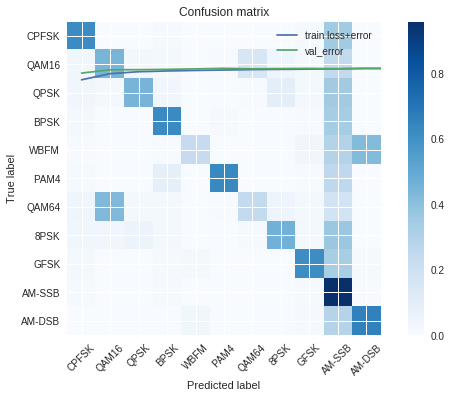

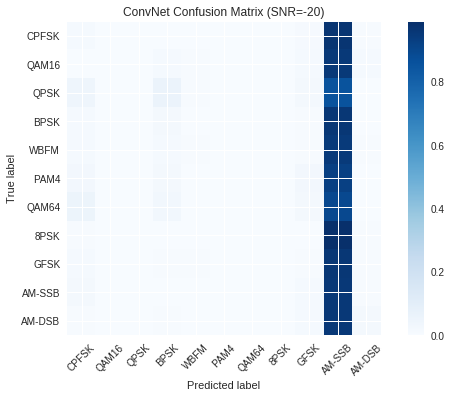

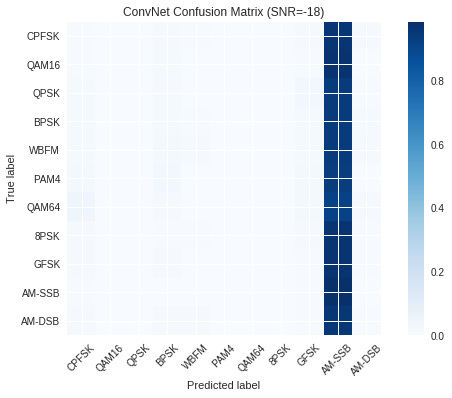

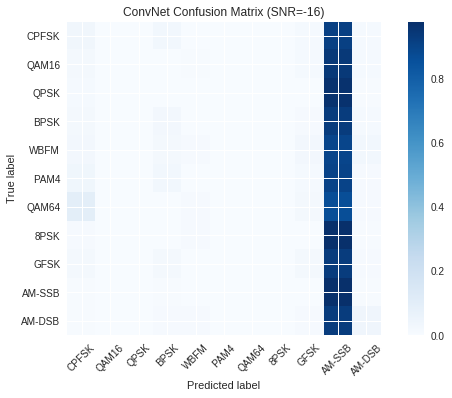

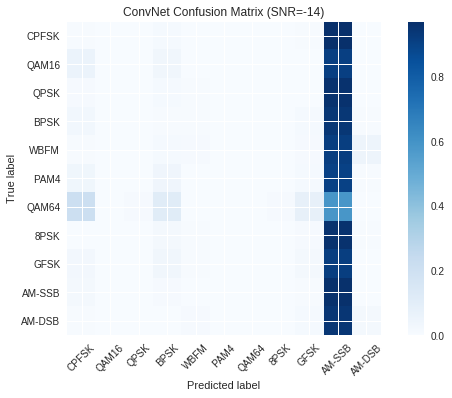

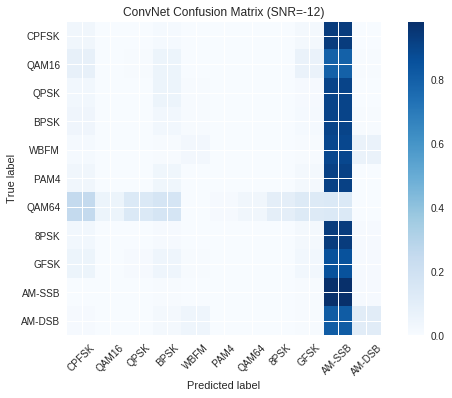

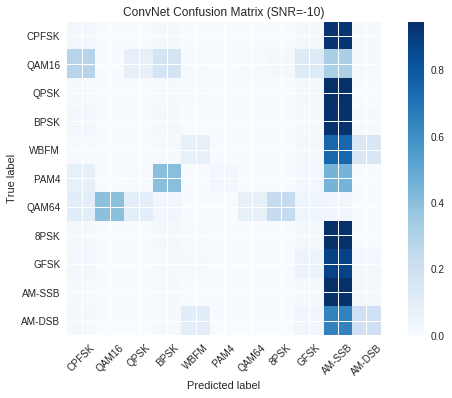

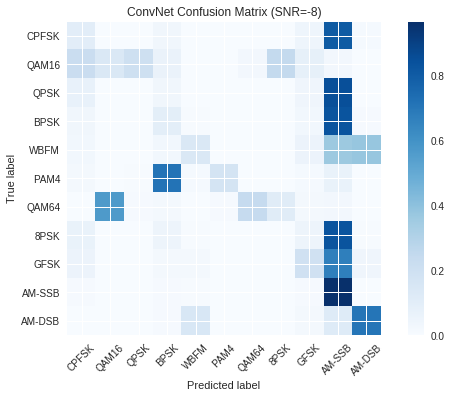

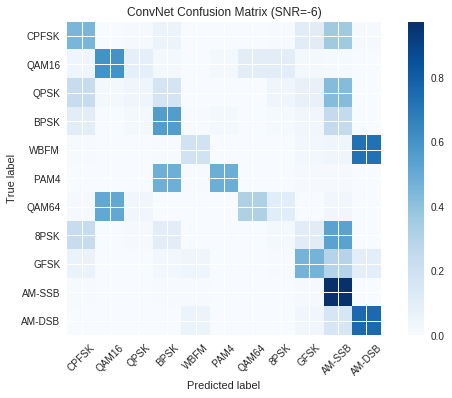

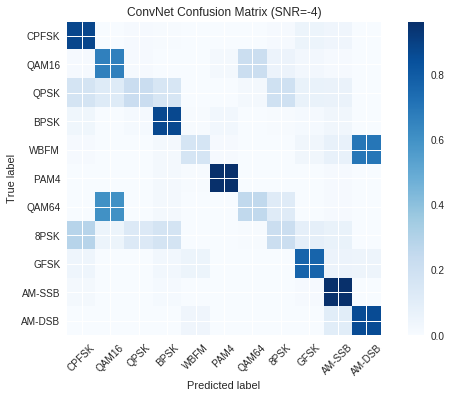

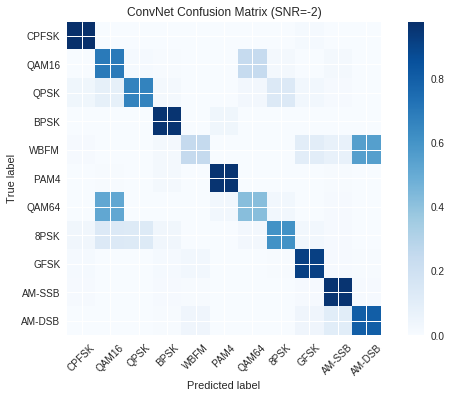

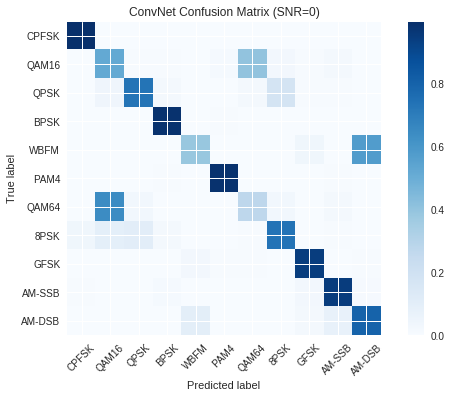

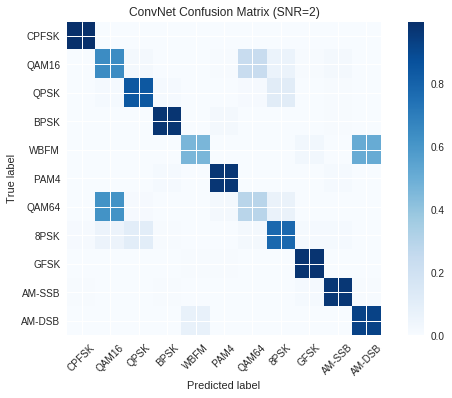

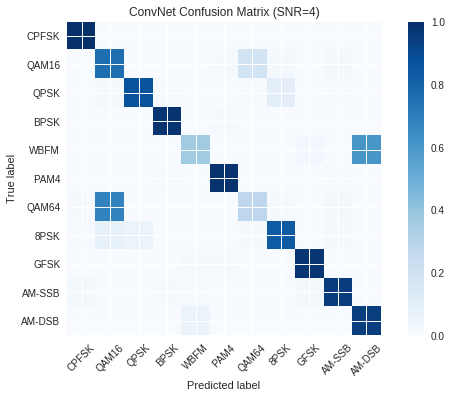

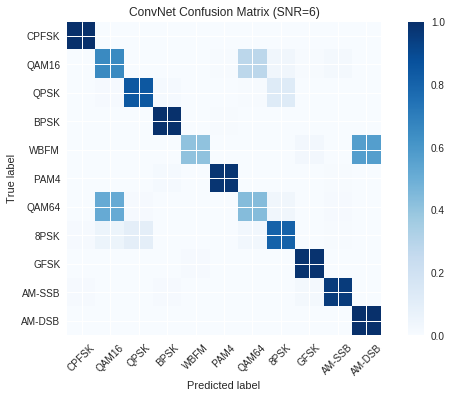

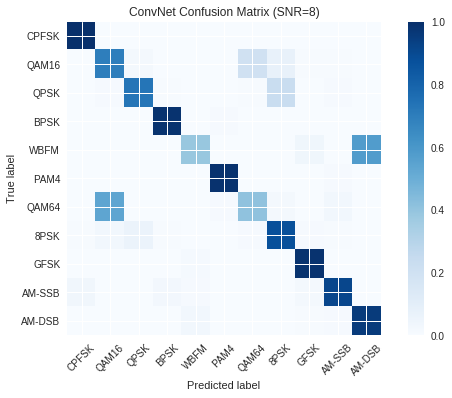

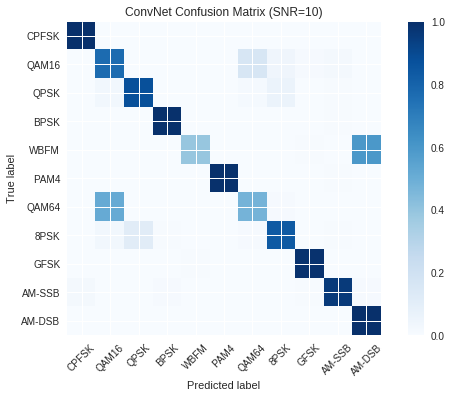

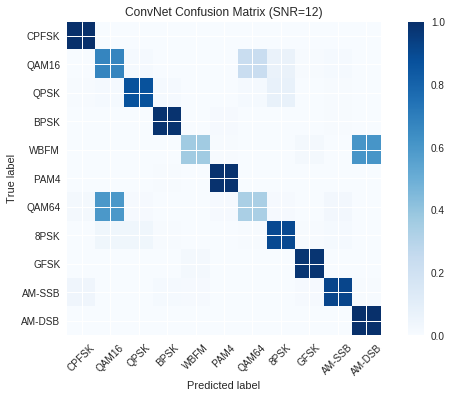

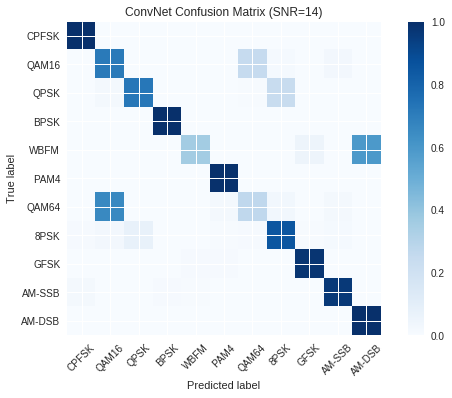

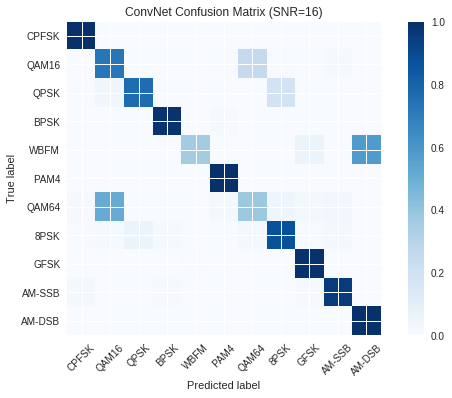

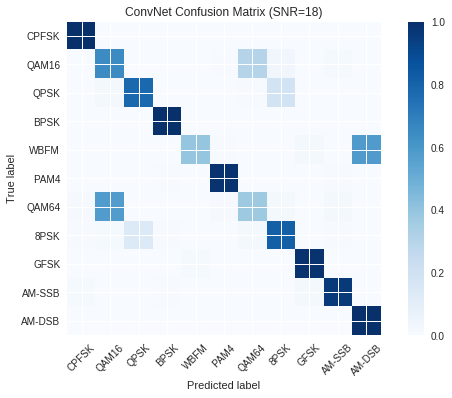

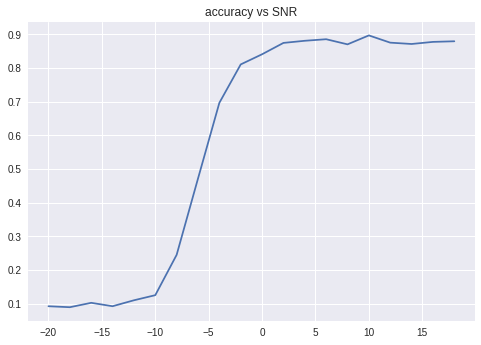

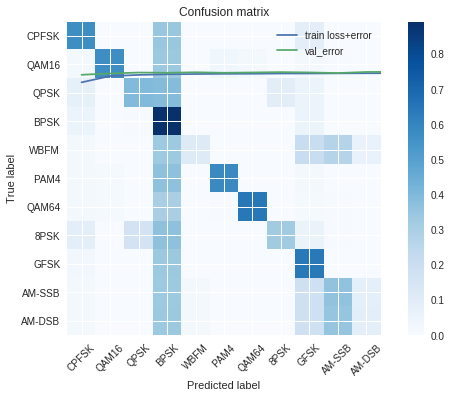

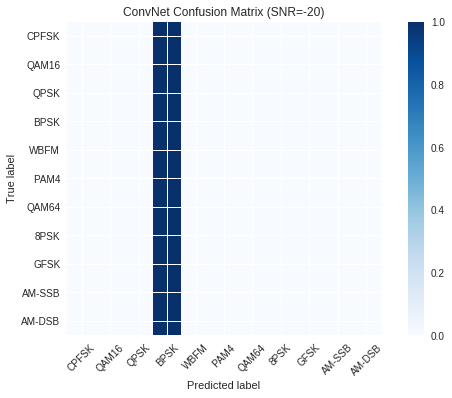

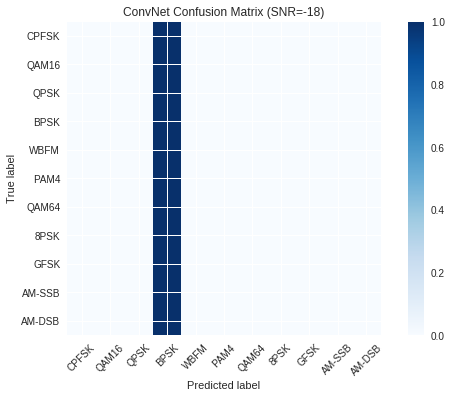

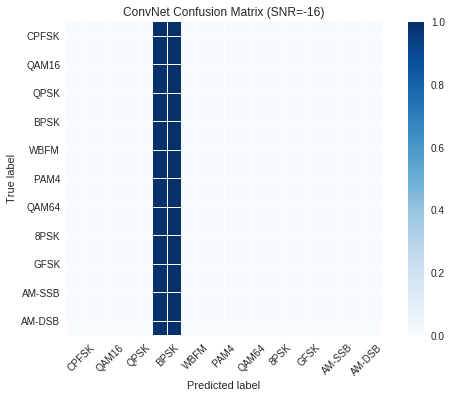

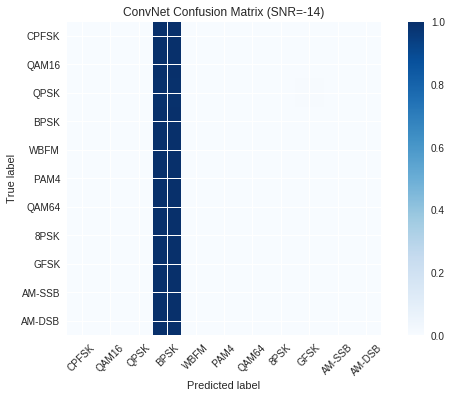

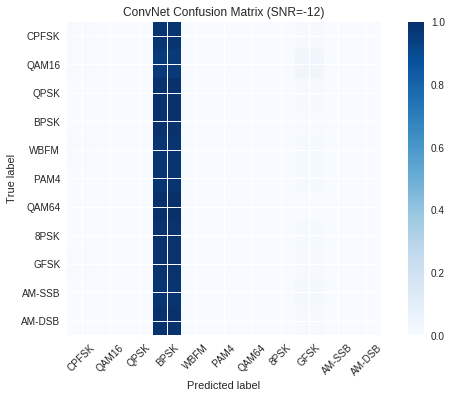

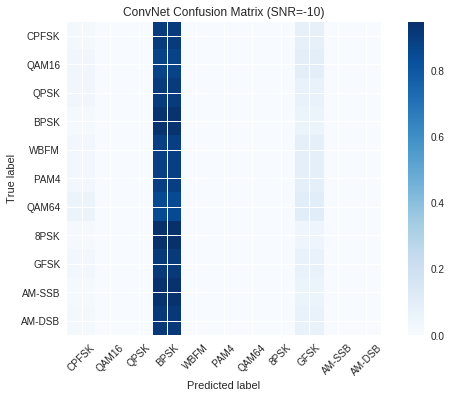

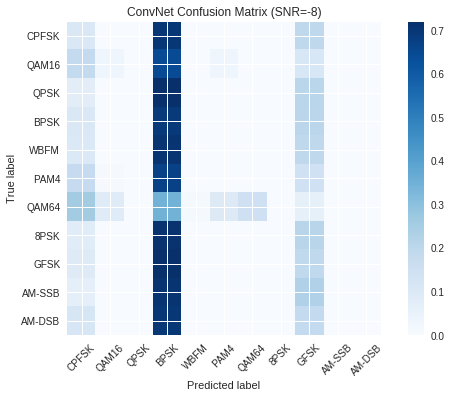

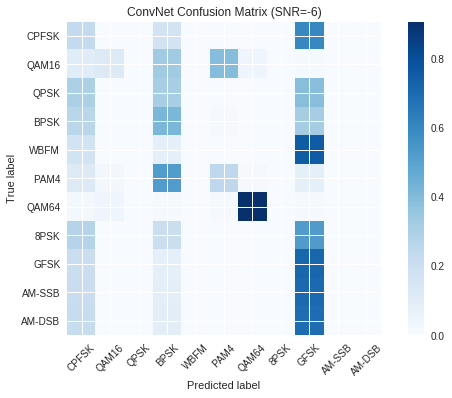

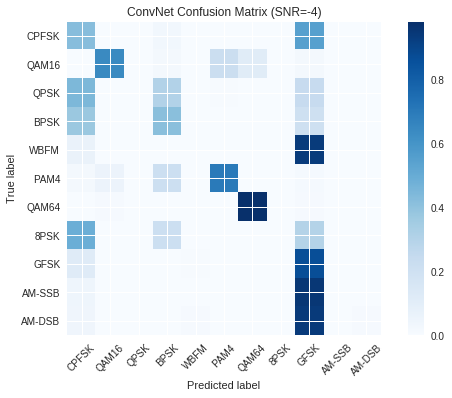

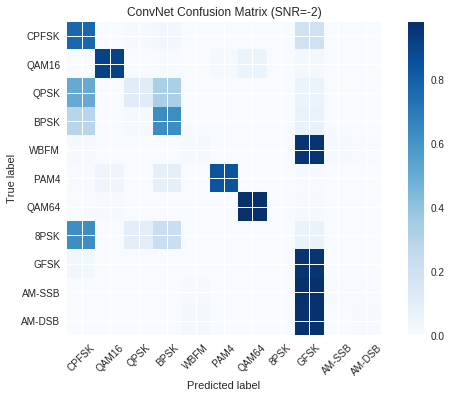

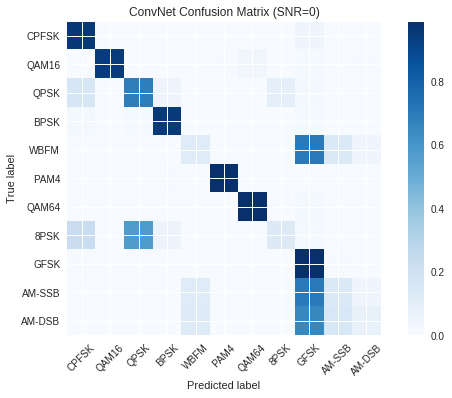

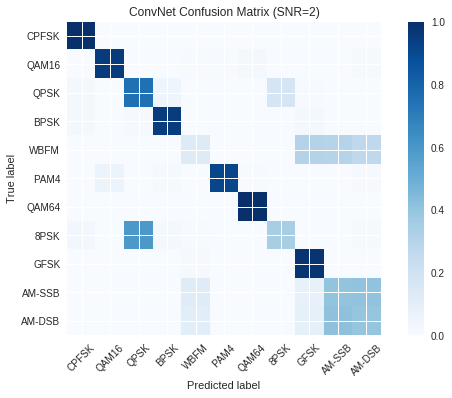

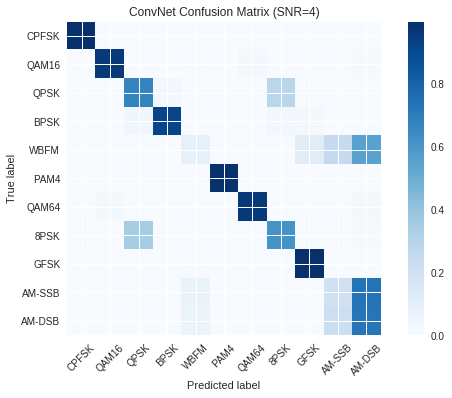

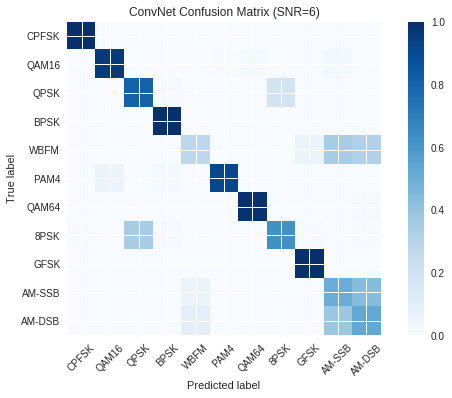

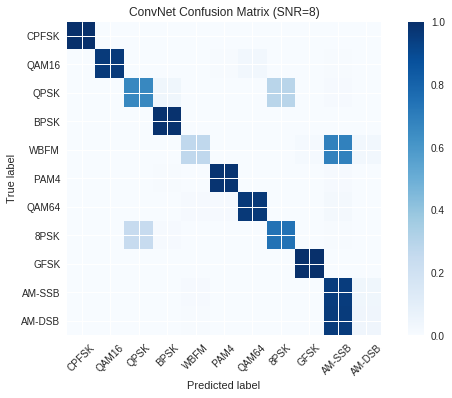

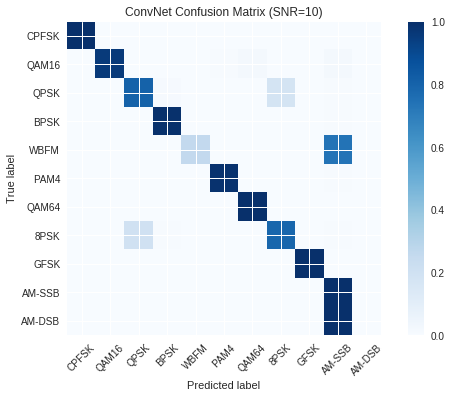

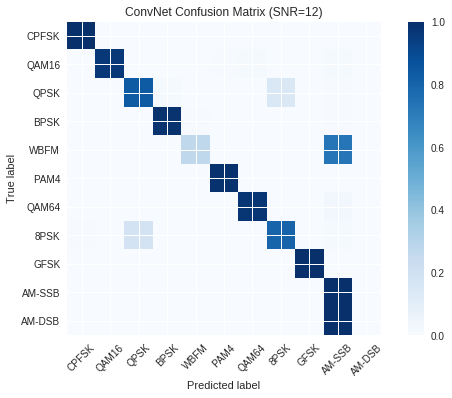

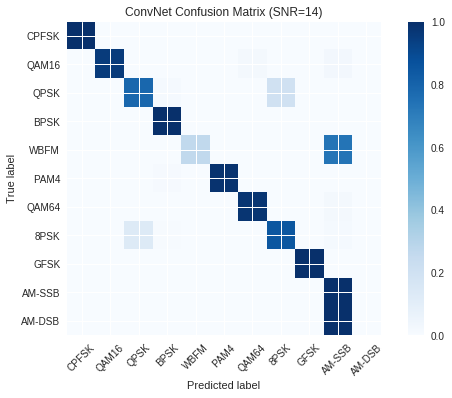

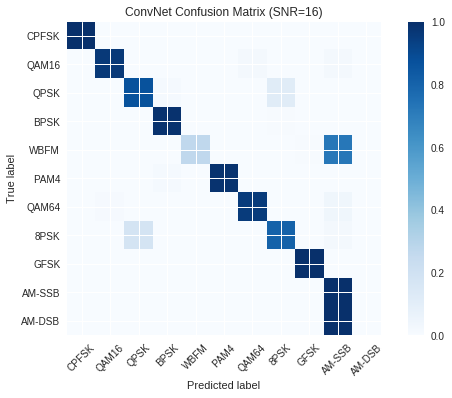

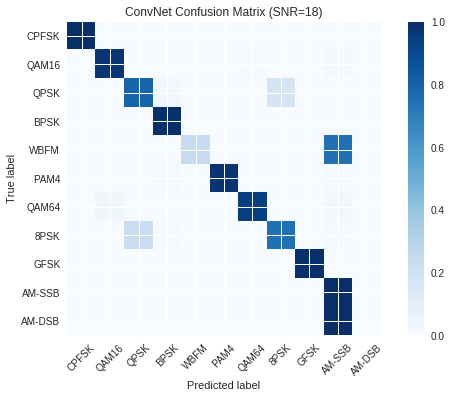

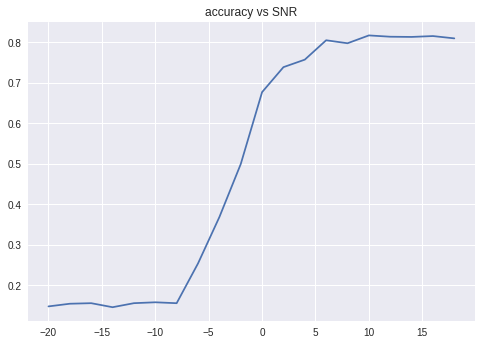

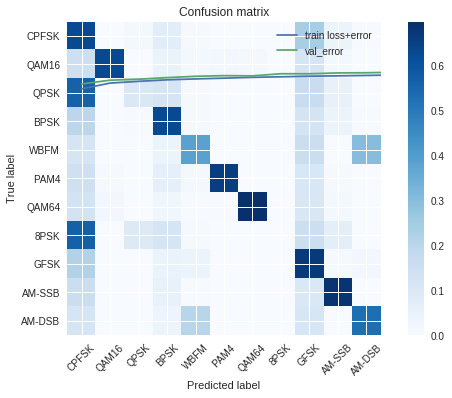

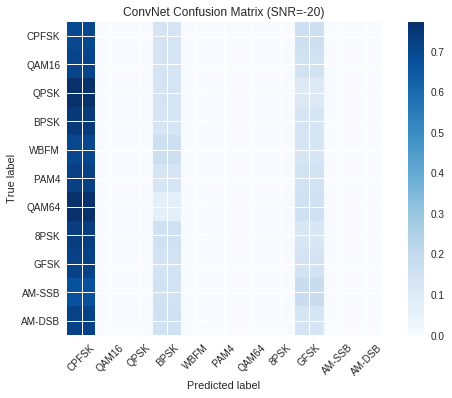

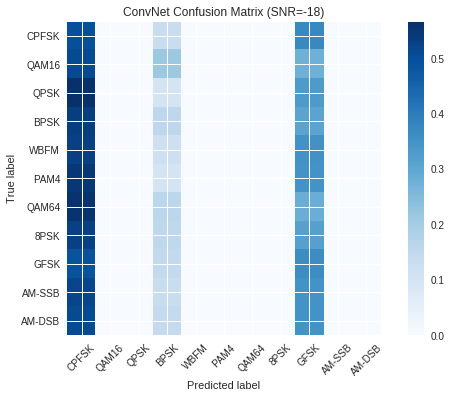

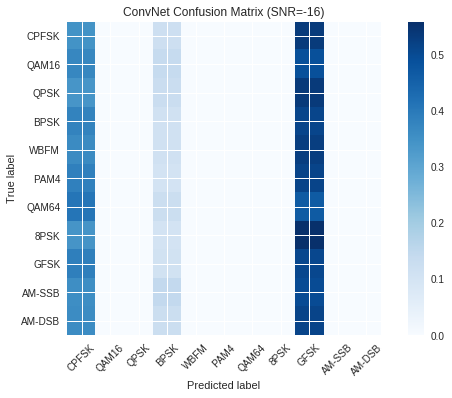

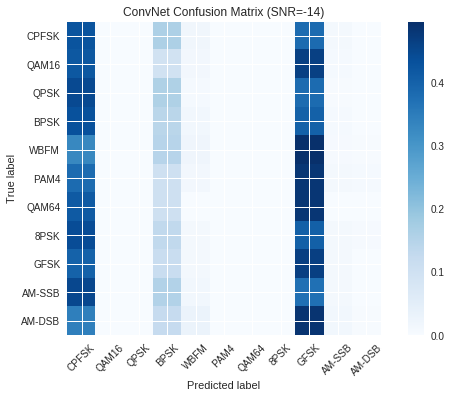

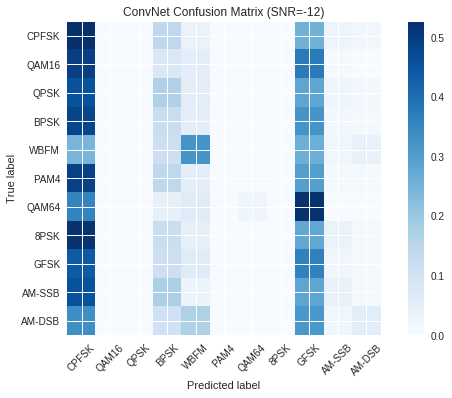

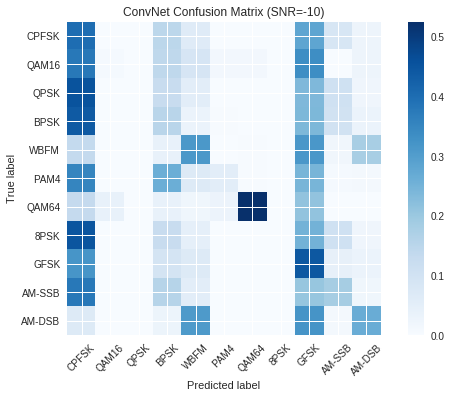

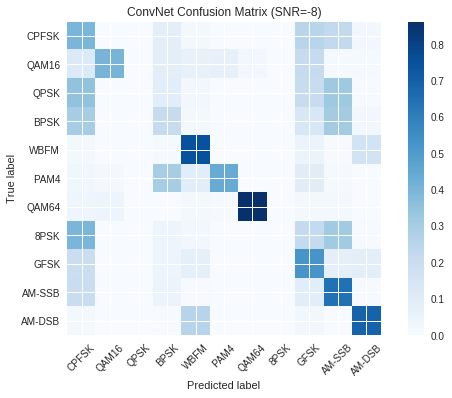

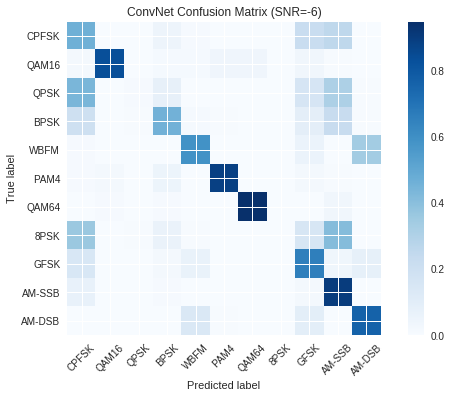

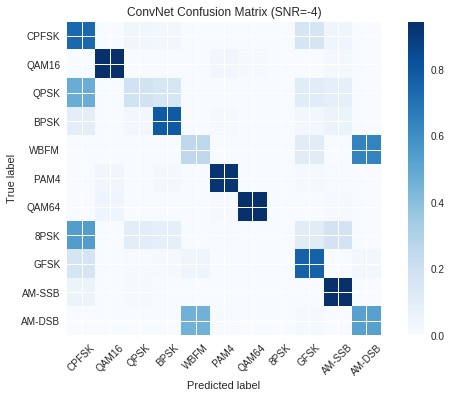

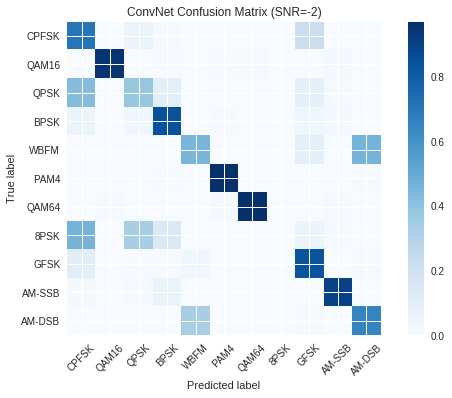

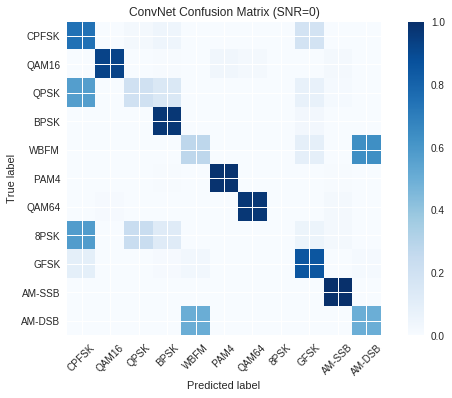

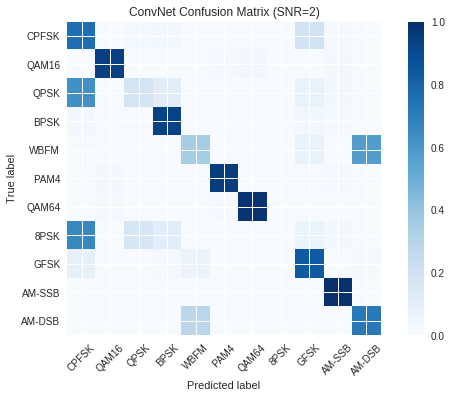

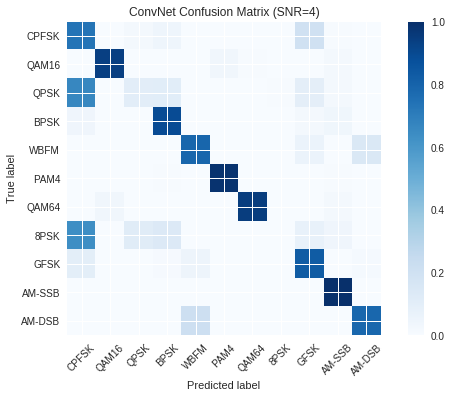

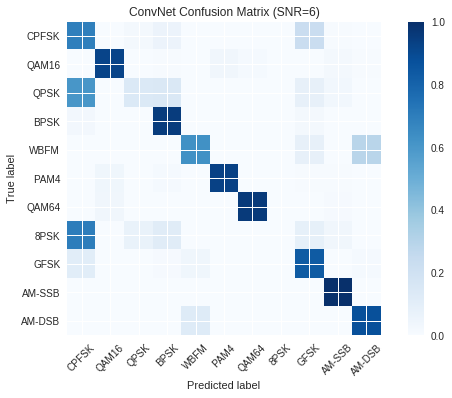

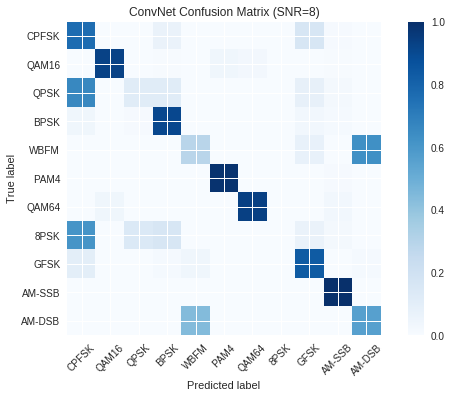

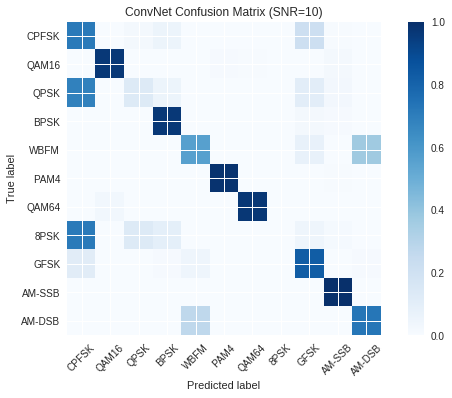

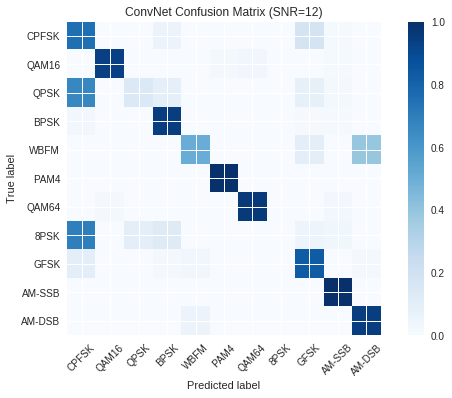

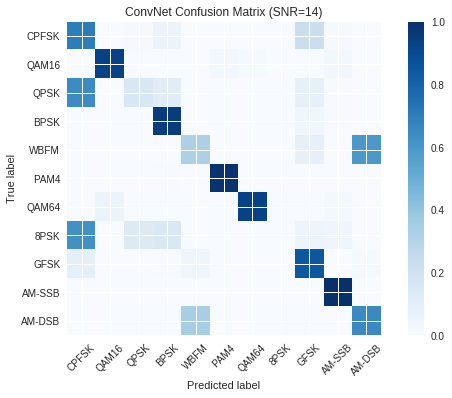

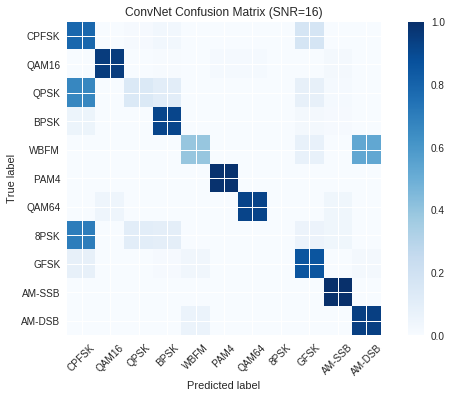

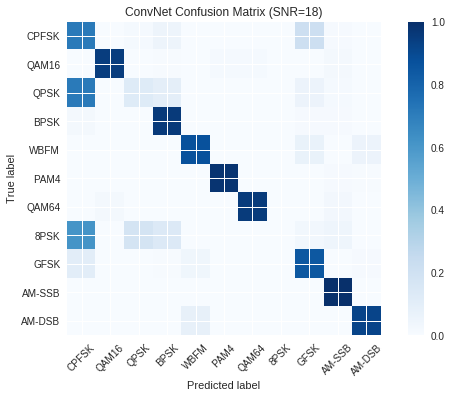

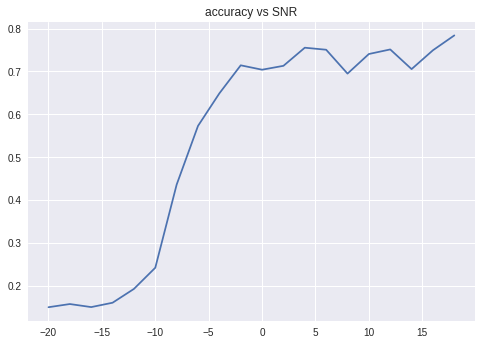

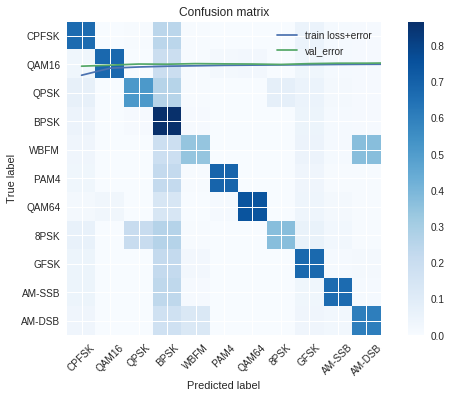

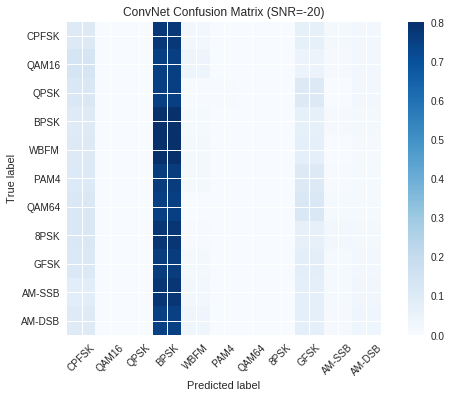

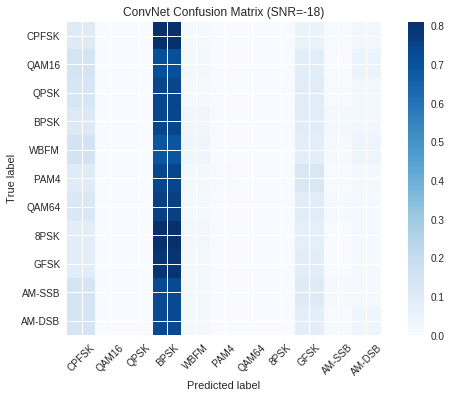

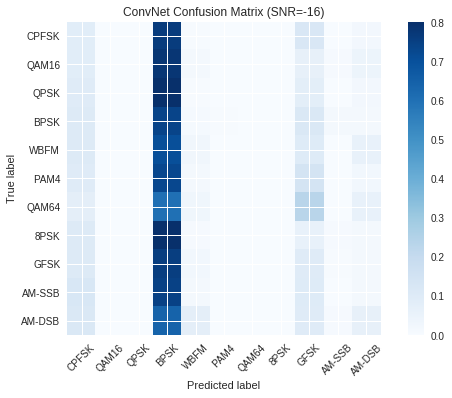

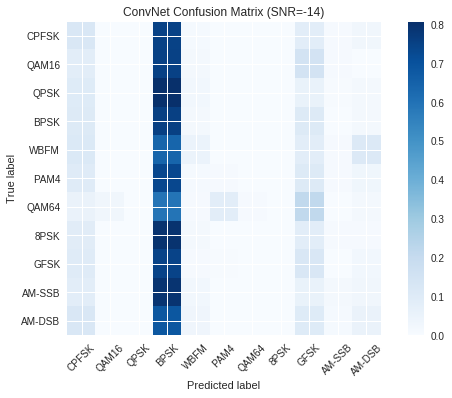

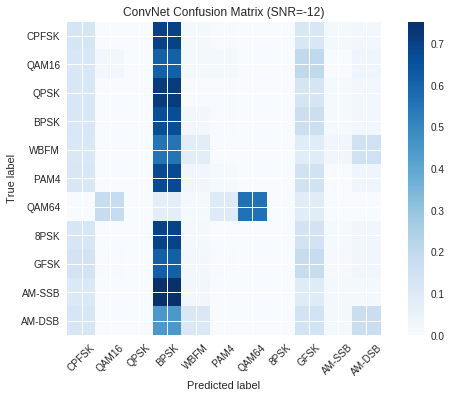

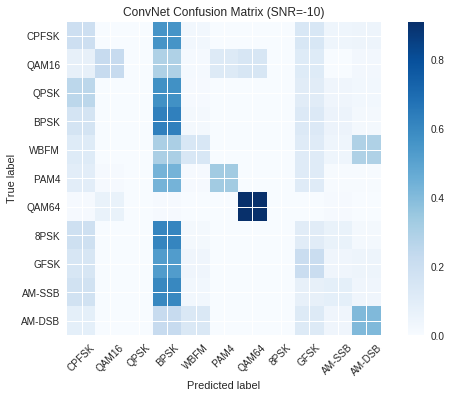

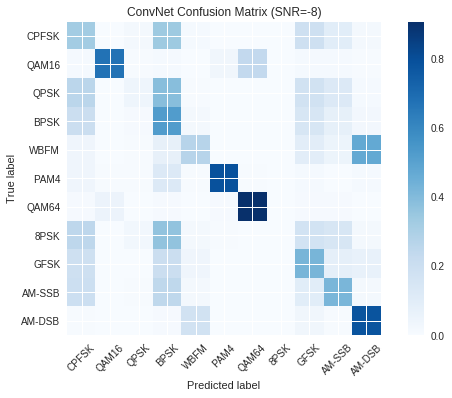

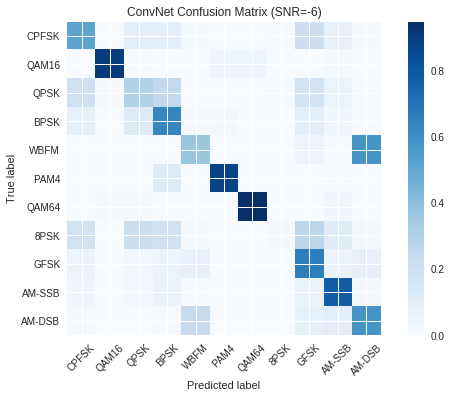

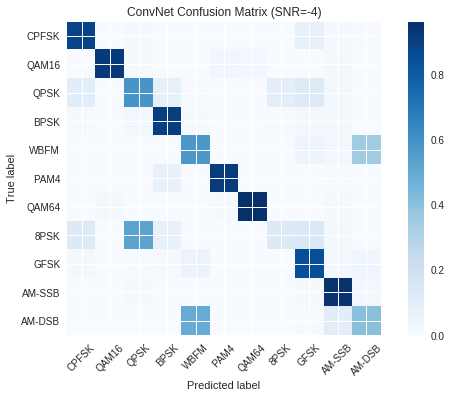

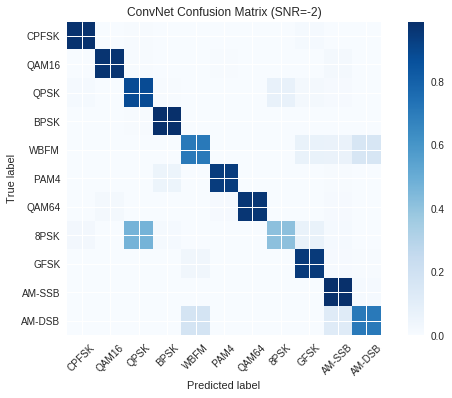

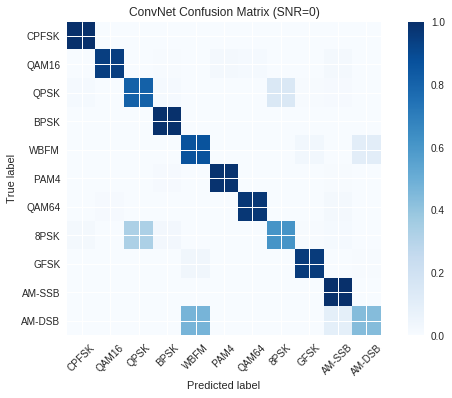

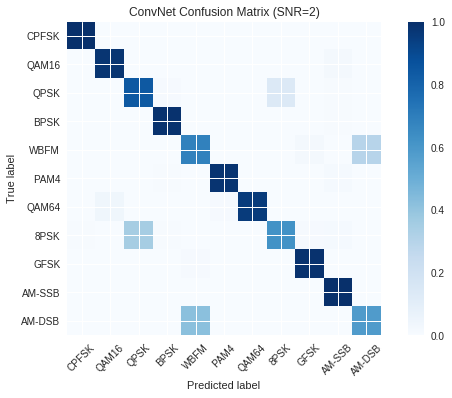

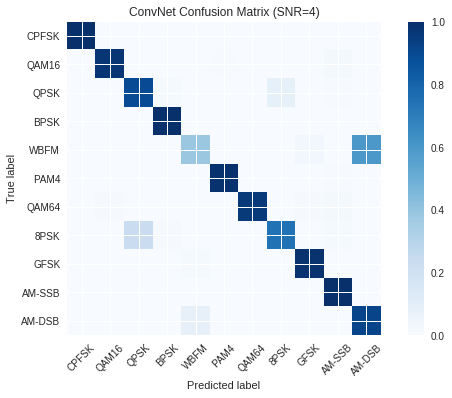

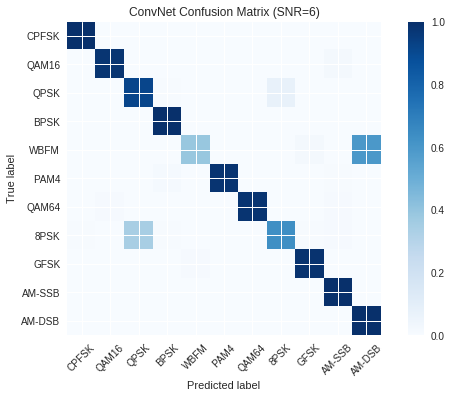

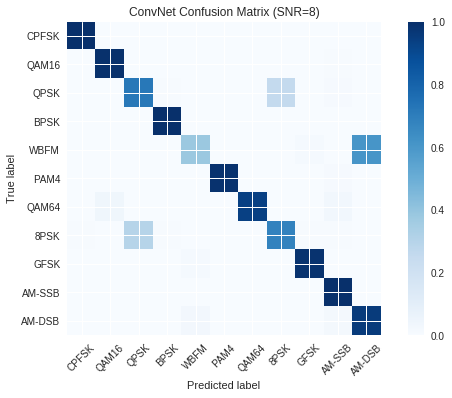

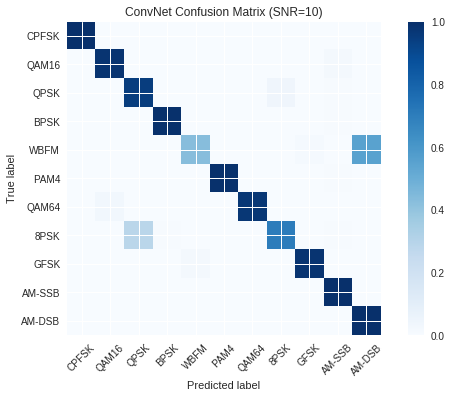

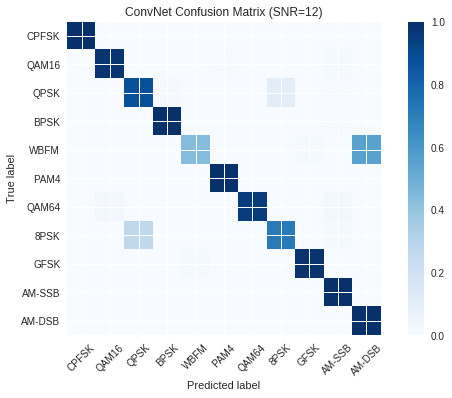

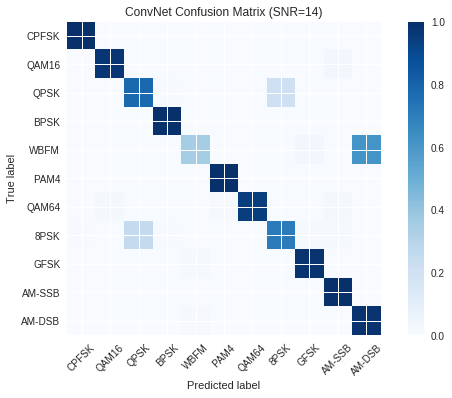

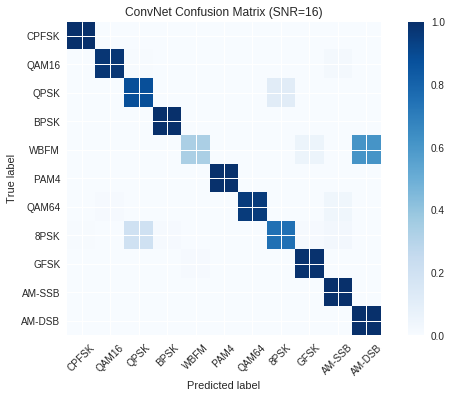

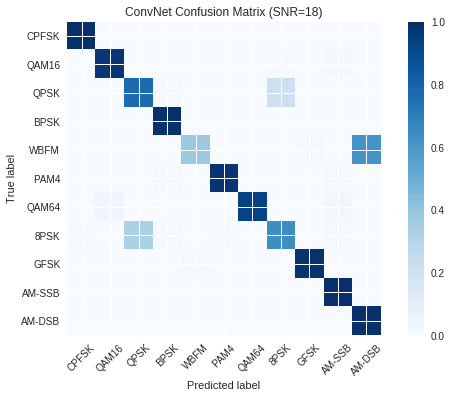

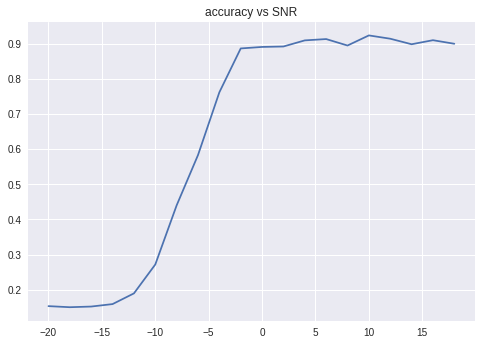

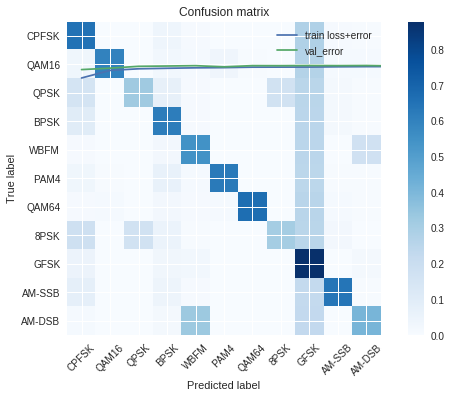

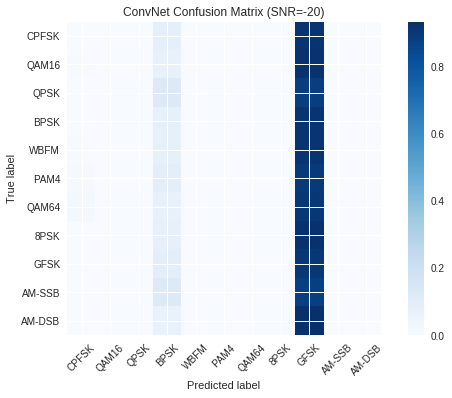

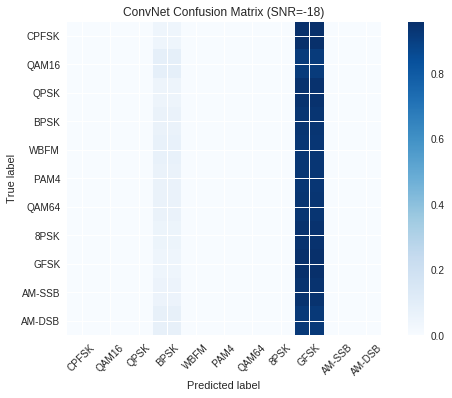

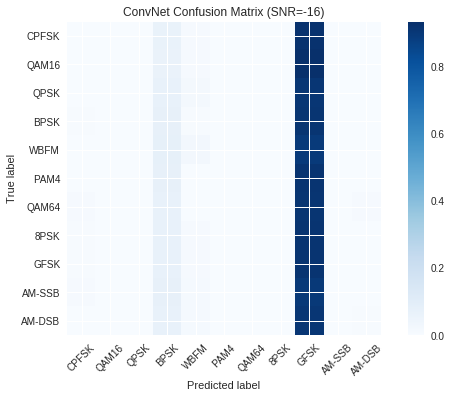

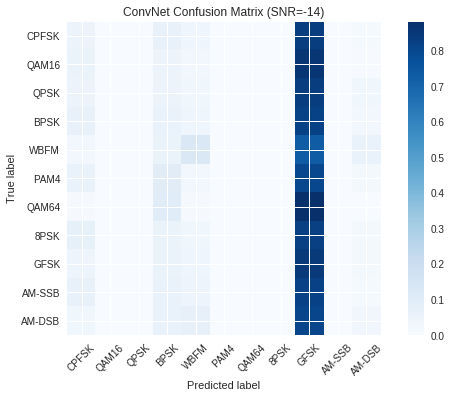

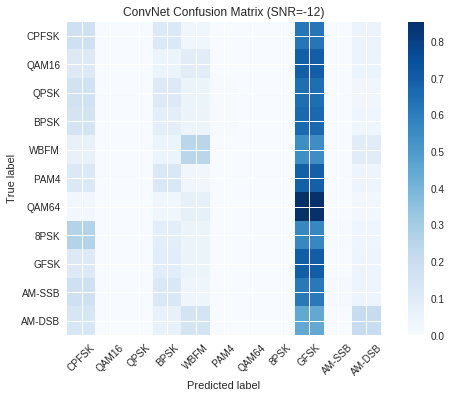

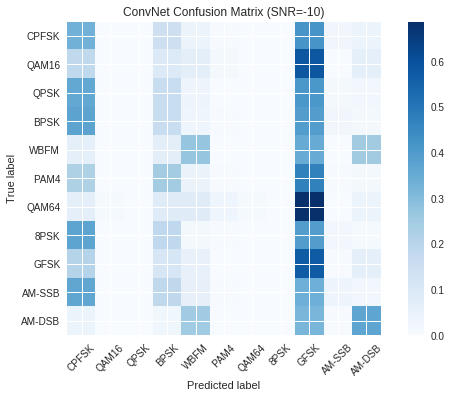

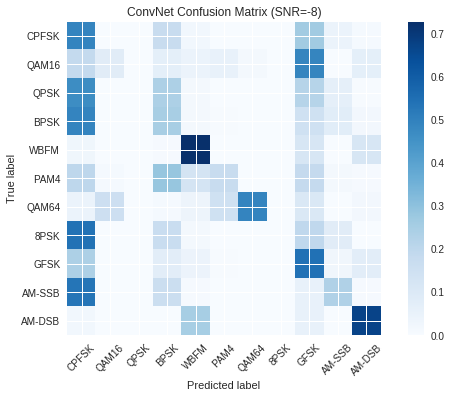

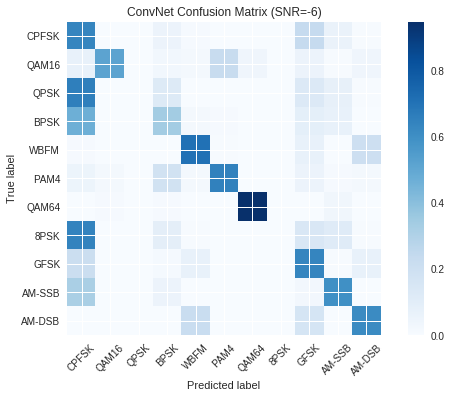

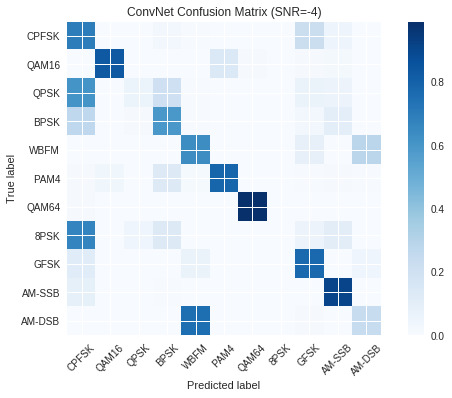

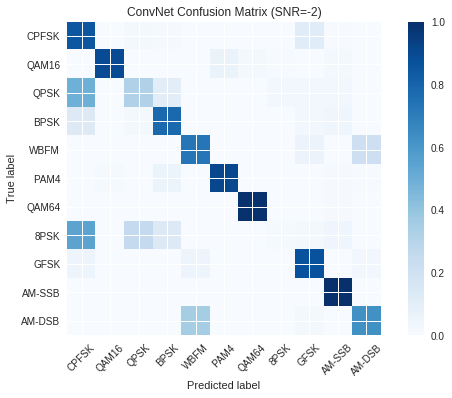

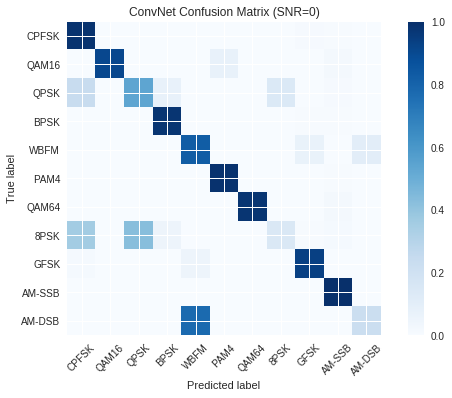

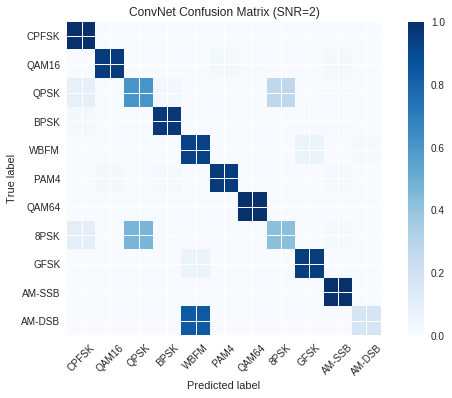

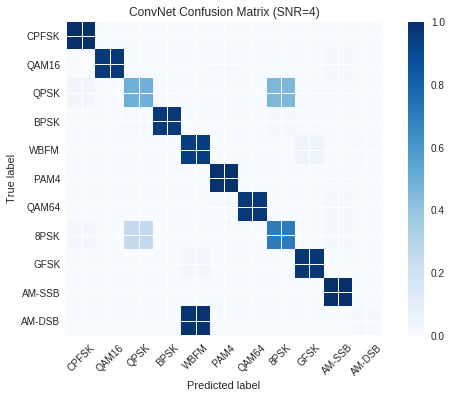

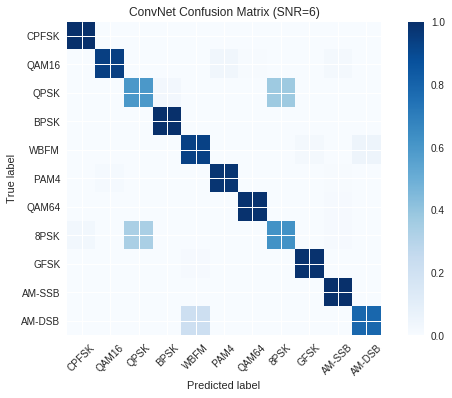

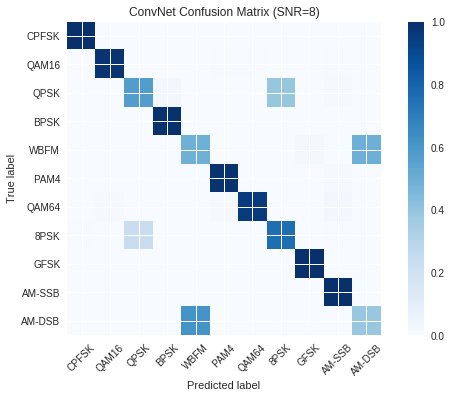

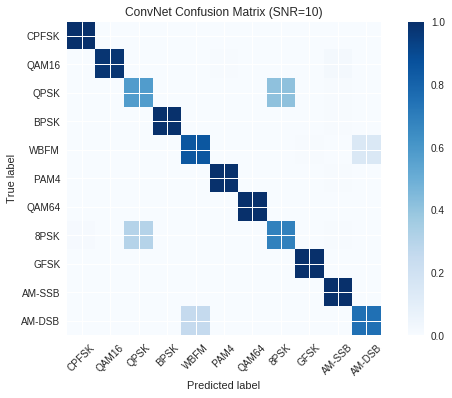

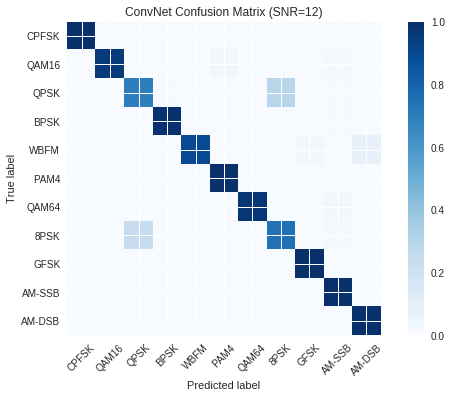

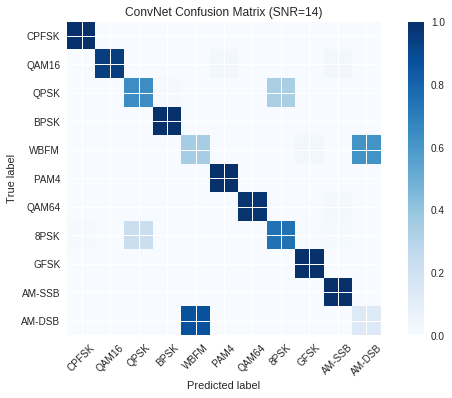

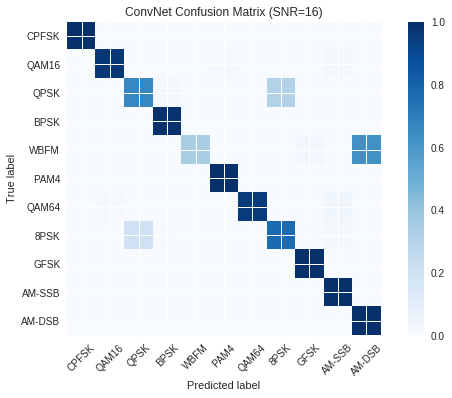

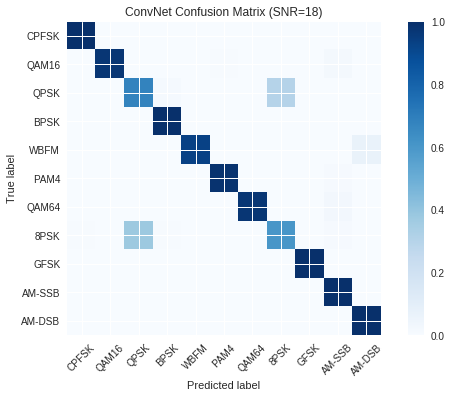

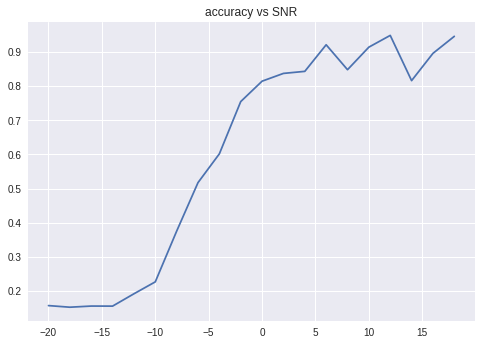

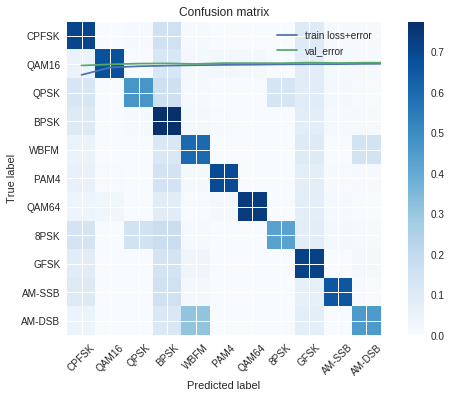

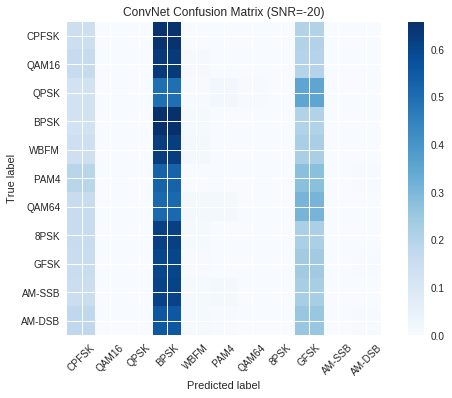

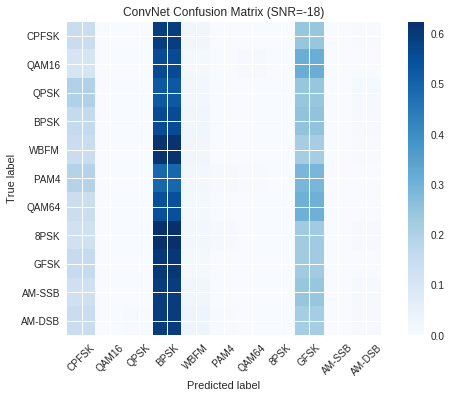

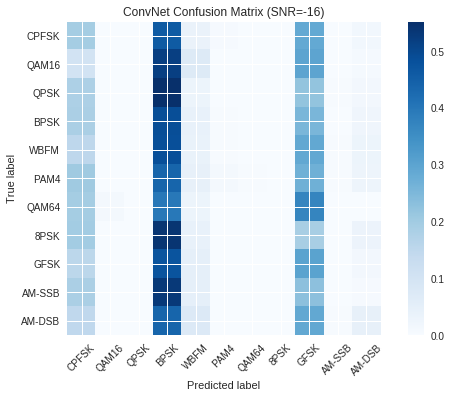

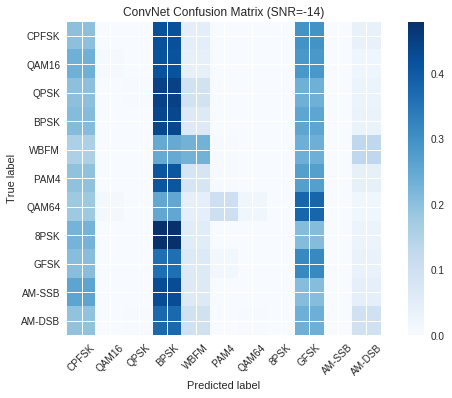

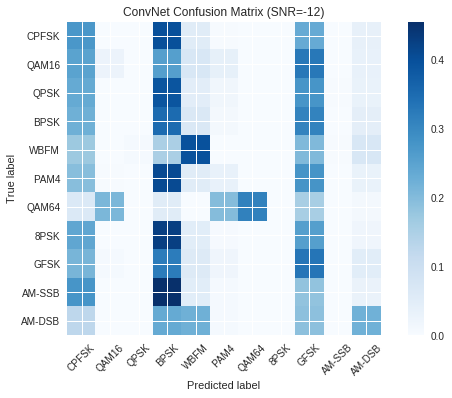

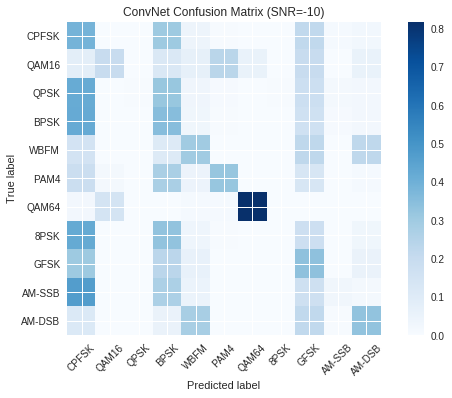

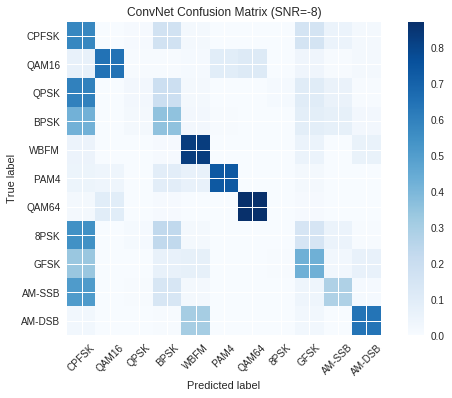

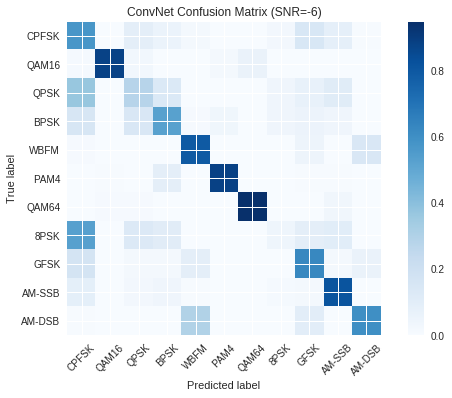

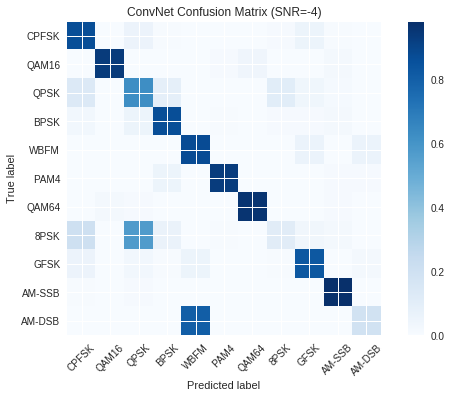

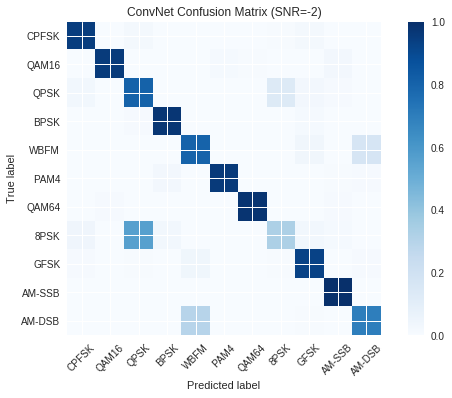

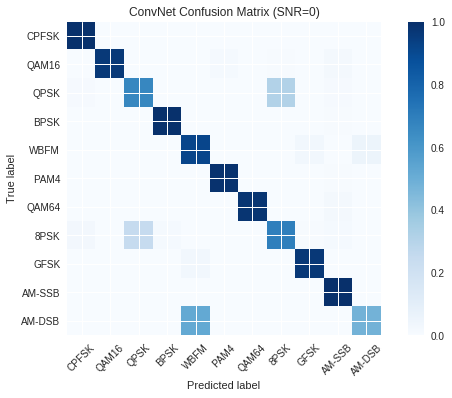

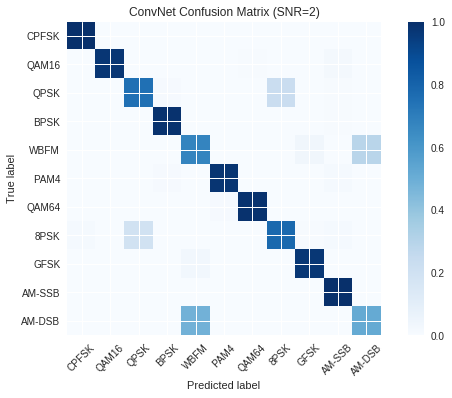

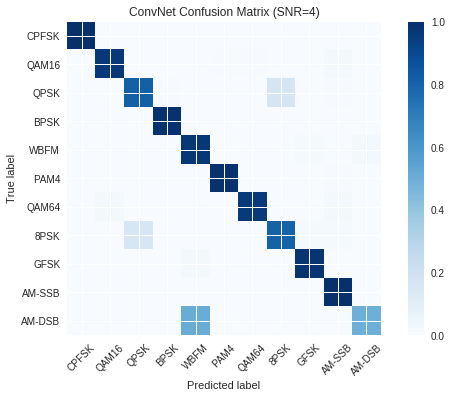

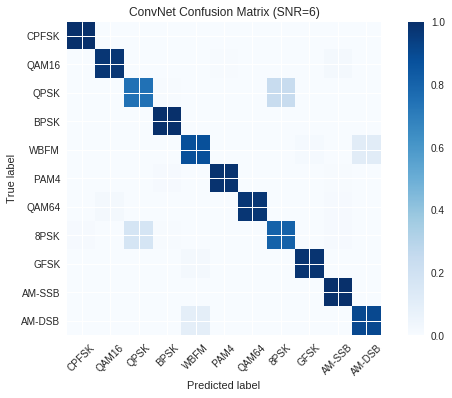

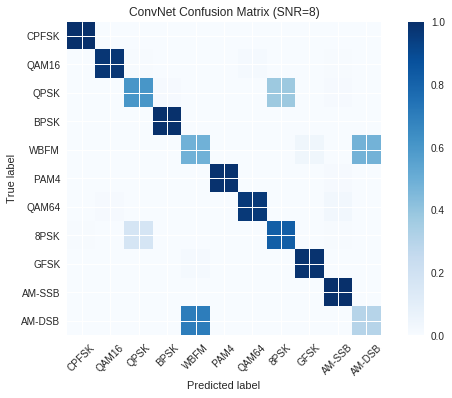

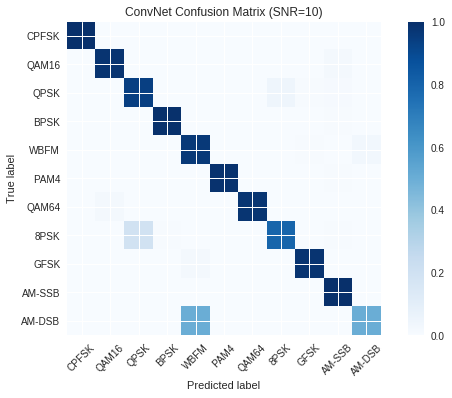

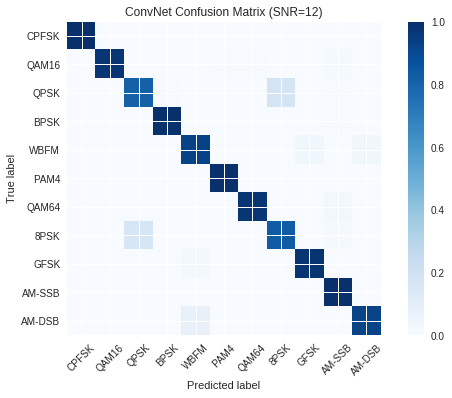

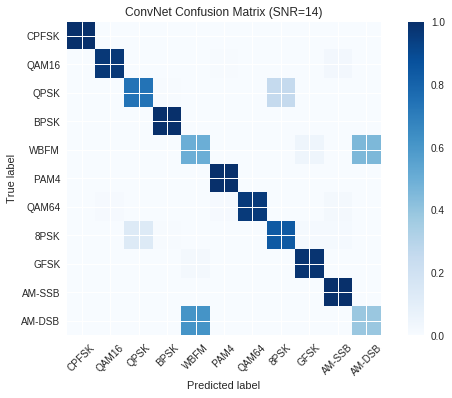

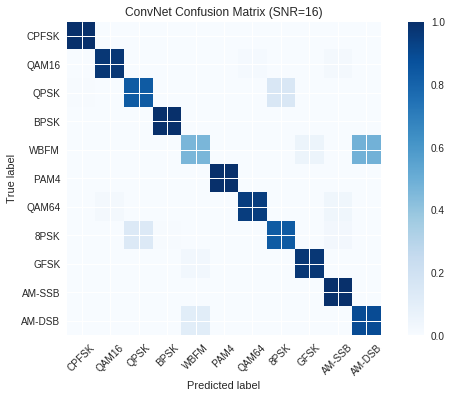

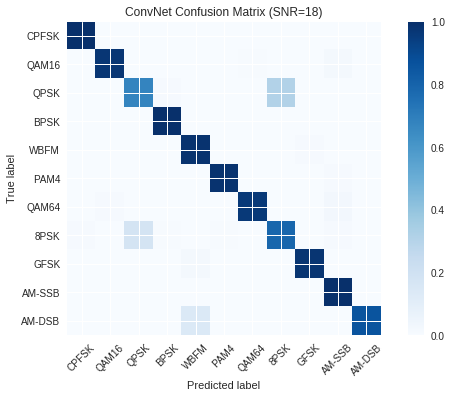

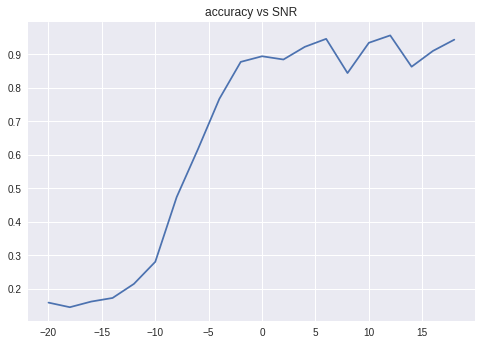

In [0]:
for idx, model in enumerate(models):
    x_train = X_train[:,params[idx][0]:params[idx][1],:].copy()
    x_test = X_test[:,params[idx][0]:params[idx][1],:].copy()
    history = model.fit(x_train, y_train, epochs=30, validation_split=0.05)
    scores = model.evaluate(x_test, y_test)
    plt.figure()
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='train loss+error')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.legend()

    # Plot confusion matrix
    batch_size = 1024
    test_y_hat = model.predict(x_test, batch_size=batch_size)
    conf = np.zeros([len(modulations),len(modulations)])
    confnorm = np.zeros([len(modulations),len(modulations)])
    for i in range(0,x_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(modulations)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, labels=modulations)

    acc = {}
    for snr in snrs:

        # extract classes @ SNR
        test_SNRs = list(map(lambda x: int(x[1]), lbl_test))
        test_X_i = x_test[np.where(np.array(test_SNRs)==snr)]
        test_y_i = y_test[np.where(np.array(test_SNRs)==snr)]

        # estimate classes
        test_y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(modulations),len(modulations)])
        confnorm = np.zeros([len(modulations),len(modulations)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_y_i[i,:]).index(1)
            k = int(np.argmax(test_y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(modulations)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        plt.figure()
        plot_confusion_matrix(confnorm, labels=modulations, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor))
        acc[snr] = 1.0*cor/(cor+ncor)

    plt.figure()
    plt.title('accuracy vs SNR')
    plt.plot(snrs, [acc[snr] for snr in snrs], label='accuracy')

In [0]:
def is_feature_included(feat_num, feat_range):
    if feat_num >= feat_range[0]//2 and feat_num < feat_range[1]//2:
        return true
    return false

In [0]:
# summary confusion matrices for each model (0 dB SNR, -4 dB SNR, 10 dB SNR, overall SNR)
# models are already fitted in the previous cell
# we will re evaluate them here on specific SNRs
summary_SNRs = [-4, 0, 10]
for model, features in zip(models, params):
    # Plot confusion matrix
    print('Feature choice: raw data = {}, derivative = {}, integral = {}' % is_feature_included(0),
          is_feature_included(1), is_feature_included(2))
    batch_size = 1024
    test_y_hat = model.predict(x_test, batch_size=batch_size)
    conf = np.zeros([len(modulations),len(modulations)])
    confnorm = np.zeros([len(modulations),len(modulations)])
    for i in range(0,x_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(modulations)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, labels=modulations)
    plt.title('overall confusion matrix')
    
    for snr in summary_SNRs:
        # extract classes @ SNR
        test_SNRs = list(map(lambda x: int(x[1]), lbl_test))
        test_X_i = x_test[np.where(np.array(test_SNRs)==snr)]
        test_y_i = y_test[np.where(np.array(test_SNRs)==snr)]

        # estimate classes
        test_y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(modulations),len(modulations)])
        confnorm = np.zeros([len(modulations),len(modulations)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_y_i[i,:]).index(1)
            k = int(np.argmax(test_y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(modulations)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        plt.figure()
        plot_confusion_matrix(confnorm, labels=modulations, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy @ SNR {}: {}", snr, cor / (cor+ncor))
        acc[snr] = 1.0*cor/(cor+ncor)

    plt.figure()
    plt.title('accuracy vs SNR')
    plt.plot(snrs, [acc[snr] for snr in snrs], label='accuracy')
    